In [18]:
# config
llm_type = 'gpt-4o' #one of: gpt-3.5-turbo, gpt-4o
initialization_params = {} #eg json version


In [19]:
import pandas as pd
import os
import json
import openai
import numpy as np
import re

from langchain.chains.query_constructor.base import AttributeInfo
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI, OpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_core.output_parsers.openai_tools import JsonOutputKeyToolsParser

from langchain_openai import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from langchain_core.tools import tool
from copy import deepcopy

if not os.environ.get("OPENAI_API_KEY"):
    import key
    key.init()
assert os.environ.get('OPENAI_API_KEY')
    
path = './model_experiment_fields_ScenarioMIP_CMIP_filename_dates.csv'
df = pd.read_csv(path)
df['collection'] = 'giss_cmip6'
df['org'] = 'NASA-GISS'
df = df[['collection', 'MIP', 'org', 'model', 'experiment', 'variant', # reorder columns
         'tableID', 'variable', 'grid', 'version', 'start_YM', 'end_YM', 'filename']]
df.columns = ['collection', 'MIP', 'org', 'model', 'experiment', 'variant', # rename columns
         'temporal resolution', 'variable', 'grid', 'version', 'start year', 'end year', 'filename']
df = df.astype(str)

# https://portal.nccs.nasa.gov/datashare/giss_cmip6/ScenarioMIP/NASA-GISS/GISS-E2-1-G/
# ssp534-over/r1i1p3f1/Amon/rsdt/gn/v20200115/
# rsdt_Amon_GISS-E2-1-G_ssp534-over_r1i1p3f1_gn_204001-210012.nc

url_col_names = df.columns[:-3].to_list() + ['filename'] # removes start/end year, filename
urldf = df[url_col_names] # working off this extra dataframe runs like 5x faster
def url(x):
    cols = '/'.join([val for val in x])
    return 'https://portal.nccs.nasa.gov/datashare/' + cols
df['URL'] = urldf.apply(lambda x: url(x), axis=1)

df['start year'] = df['start year'].apply(lambda x: int(x[:4])) #+'-'+x[4:])
df['end year'] = df['end year'].apply(lambda x: int(x[:4])) #+'-'+x[4:])

oldn = df.shape[0]
# keep only the latest version of each dataset
df = df.sort_values(df.columns.to_list(), ascending=True).drop_duplicates(
    subset=set(df.columns.to_list())-set(['version', 'filename', 'URL']),
    ignore_index=True, keep='last')
print('removed', oldn-df.shape[0], 'rows corresponding to old-version datasets')

# go from "Amon"->"mon", for instance
def clean_resolution(reso):
    resos = ['hr', 'day', 'mon']
    for q in resos:
        if q in reso:
            return q
    return 'NA'
df['temporal resolution'] = df.apply(lambda x: clean_resolution(x['temporal resolution']), axis=1)

#read in info on the variables in CMIP6
path = '../../cmip6-cmor-tables/Tables'
jdfs = []
for fname in os.listdir(path):
    with open(os.path.join(path, fname)) as j:
        d = json.load(j)
    
    try: 
        jdf = pd.DataFrame.from_dict(d['variable_entry'], orient='index')
    except:
        print('skipping', fname, 'due to formatting issue')
        continue    
    
    jdf['temporal resolution'] = fname[len('CMIP6_'):-len('.json')]
    jdfs.append(jdf)
    
varsdf = pd.concat(jdfs)
varsdf.rename(columns={'out_name': 'variable'}, inplace=True)
varsdf = varsdf.loc[:, ['long_name', 'comment', 'variable']]
varsdf.drop_duplicates(inplace=True)
varsdf['extended_comment'] = varsdf.apply(lambda x: str(x['long_name'])+' ('+str(x['variable'])+'): ' + str(x['comment']), axis=1)

varsdf = varsdf[varsdf['variable'].isin(df['variable'].unique())] # keep only variables in 
df = df[df['variable'].isin(varsdf['variable'])]
print('varsdf has', len(varsdf), 'rows and datasets df has', len(df), 'rows')

removed 6985 rows corresponding to old-version datasets
skipping CMIP6_coordinate.json due to formatting issue
skipping CMIP6_input_example.json due to formatting issue
skipping CMIP6_CV.json due to formatting issue
skipping CMIP6_formula_terms.json due to formatting issue
varsdf has 419 rows and datasets df has 296509 rows


In [3]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
# varsdf.loc[varsdf['extended_comment'].isna(), 'extended_comment'] = ''
# embs = np.asarray(embeddings.embed_documents(varsdf['extended_comment']))
varsdf.loc[varsdf['long_name'].isna(), 'long_name'] = ''
embs = np.asarray(embeddings.embed_documents(varsdf['long_name']))
varsdf['embeds'] = list(embs) 

@tool 
def find_relevant_variables(keywords):
    """search dataframe of CMIP6 variables, to find relevant variables to a list of keywords"""
    if type(keywords) == list:
        keywords = ' '.join(keywords)
    # print(keywords)
    # print(keywords)
    emb = np.asarray([embeddings.embed_query(keywords)])
    docslist = varsdf['embeds'].to_list()
    docslist.extend(emb)
    sims = cosine_similarity(np.stack(docslist))
    sims = sims[-1, :-1]  # row -1 is the keywords, all other rows are the variable descriptors
    simssort = np.argsort(sims)[::-1]
    dfmatch = deepcopy(varsdf.iloc[simssort,:])
    dfmatch.loc[:,'score'] = sims[simssort]
    return dfmatch

# find_relevant_variables('maximum temperature')

In [3]:
# query summarizer agent
llm=ChatOpenAI(temperature=0, model=llm_type, )
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "summarize the user's request in a few key words without punctuation. "
    "Do NOT attempt to answer the user's request. "
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
chain_standalone = contextualize_q_prompt | llm | StrOutputParser()

## Climate PAL retrievals component

In [6]:
#variabless agent
llm_with_tools = llm.bind_tools([find_relevant_variables], tool_choice=find_relevant_variables.name)
parser = JsonOutputKeyToolsParser(key_name=find_relevant_variables.name, first_tool_only=True)

system = f"""
You are a climate scientist and expert on CMIP6. Given a colleague's query, describe what 
CMIP6 variable you would use to answer the query. For instance, you might want a rainfall-related 
variable for questions about drought. For a query about days below freezing, you might want a variable 
describing minimum temperature instead of average temperature. Formulate your response as a detailed 
list of keywords. Be specific because a lot of CMIP6 variables are very similar but there is only one 
correct answer to these queries.
"""
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
varagent = prompt | llm_with_tools | parser | find_relevant_variables

system2 = f"""
RETURN EXACTLY A ONE-WORD RESPONSE FOR THE FOLLOWING:
You are an expert climate scientist working with the CMIP6. Following, is a colleague's climate analysis 
query and a list of 10 CMIP6 variables with their descriptions. From these 10 variables, choose the variable 
best-suited to answer the colleague's query. 

HEED THE FOLLOWING!!!!!!!!!!!:
Return ONLY the variable's name and nothing else. For instance, 
return 'tas', or 'zostoga', or 'sithick' alone, no explanation, no alternative answer, nothing else.
Your response should be EXACLY one word in length.
"""
prompt2 = ChatPromptTemplate.from_messages([("system", system2), ("human", "{question}"),])
varagent2 = prompt2 | llm  

# conversation = {'input': "Average annual days surface air temperature exceeds 98°F in 2050-2070",
#                 'chat_history': []}
# standalone = chain_standalone.invoke(conversation)
# print(standalone)
# varagent.invoke(standalone)

In [7]:
# temporal resolution agent
temporalmsg = f"""You are an expert climate scientist. Is the following CMIP6-related query 
best answered using data gathered at which of the following resolutions? 
A. hour
B. day
C. month
D. not applicable, none of the above, or unclear
Respond with only the one letter corresponding to your choice and nothing else. If a query does 
not specify any given temporal resolution, like the query "plot average temperature", then choose 
option D.
"""
temporalprompt = ChatPromptTemplate.from_messages([('system', temporalmsg), ('human', '{question}')])
temporalagent = temporalprompt | llm 
key = {'A': 'hr', 'B': 'day', 'C': 'mon', 'D': 'NA'}

def temporalagentparsed(query):
    pred = temporalagent.invoke(query).content
    return key.get(pred[0], 'NA')

# temporalagent.invoke(' frost data')

In [8]:
# year range agent
yearmsg = f"""You are an expert climate scientist. Does the following CMIP6 query require or specify 
a year range for the data required to answer the query? If yes, provide the year range in format 
START-END, for instance 1960-1970 or 2100-3100. If no, respond NA-NA. If only the start or end is 
specified, provide just that year in format START-NA (eg 2100-NA) or NA-END (eg NA-1900).
Provide only the year range in this format and nothing else.
"""
yearprompt = ChatPromptTemplate.from_messages([('system', yearmsg), ('human', '{question}')])
yearagent = yearprompt | llm

def yearagentparsed(standalone):
    string = yearagent.invoke(standalone).content
    start, end = string.split('-')
    if start != 'NA':
        start = int(start)
    else: 
        start = float('Inf')
    if end != 'NA':
        end = int(end)
    else:
        end = -1*float('Inf')
    return start, end

# yearagentparsed('average temperature in 20th century')

In [20]:
str(list(df['MIP'].unique()))

"['CMIP', 'ScenarioMIP']"

In [9]:
# MIP agent
mips = str(list(df['MIP'].unique()))
mipmsg = f"""You are an expert climate scientist working with CMIP6. 
Here is a list of the MIPs you work with: 
{mips}

To answer the following query, which of the above experiments would you use?
Return JUST the name of the experiment and nothing else. If the choice of experiment
does not matter, return 'None'.
"""
mipprompt = ChatPromptTemplate.from_messages([('system', mipmsg), ('human', '{question}')])
mipagent = mipprompt | llm 
# mipagent.invoke('Plot the projected surface temperature anomaly for North America under SSP370 in 2100')

In [4]:
# experiment agent
exps = str(list(df['experiment'].unique()))
expmsg = f"""You are an expert climate scientist working with CMIP6. 
Here is a list of the experiments you work with: 
{exps}

To answer the following query, which of the above experiments would you use?
Return JUST the name of the experiment and nothing else. If the choice of experiment
does not matter, return 'None'.
"""
expprompt = ChatPromptTemplate.from_messages([('system', expmsg), ('human', '{question}')])
expagent = expprompt | llm 
# expagent.invoke('Plot the projected surface temperature anomaly for North America under SSP370 in 2100')

## Baselines

In [5]:
# variable pandas agent
prefix="""You are an expert climate scientist working with CMIP6. For the following climate 
analysis-related query, provide the name of the one CMIP6 variable you would use to answer 
the query. To help you, you have a dataframe of each CMIP6 variable, where the columns 
describe the variable. Do not expect variable names to be an exact match! Look for specific 
relevant keywords in their descriptions instead."""
base_varpd = create_pandas_dataframe_agent(
    llm,
    varsdf[['long_name', 'comment', 'variable', 'extended_comment']],
    prefix=prefix,
    agent_type="tool-calling",
    verbose=False,
    allow_dangerous_code=True
)
# base_varpd.invoke('plot average surface temperature').output

In [6]:
# variable embeddings search
find_relevant_variables('maximum temperature').iloc[0]['variable']

/Users/snc/opt/anaconda3/envs/giss2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'tasmax'

In [7]:
# years
def base_years(query):
    matches = re.findall(r'[12][0-9]{3}', query)
    years = [int(match) for match in matches]
    if len(years) == 0:
        return -1*float('inf'), float('inf')
    elif len(years) == 1:
        return years[0], years[0]
    else:
        return years[0], years[-1]

# base_years('2000,')

In [8]:
df['temporal resolution'].unique()

array(['mon', 'hr', 'day'], dtype=object)

In [9]:
# temporal resolution
synonyms = {'mon':['month', 'monthly', 'mon'], 'hr':['hour', 'hourly', 'hr'], 'day':['day', 'daily']}
def base_reso(query):
    query = query.lower()
    for reso, syns in synonyms.items():
        for syn in syns:
            if syn in query:
                return reso 
    return None

In [10]:
# search for MIPs
def base_mipf(query):
    query = query.lower()
    mips = list(df['MIP'].unique())
    for mip in mips:
        if mip in query:
            return mip
    return None

In [11]:
# search for experiments
def base_expf(query):
    query = query.lower()
    exps = list(df['experiment'].unique())
    for exp in exps:
        if exp in query:
            return exp 
    return None

In [12]:
# dataset pandas agent
llm=ChatOpenAI(temperature=0, model=llm_type, )
prefix="""You are an expert climate scientist working with CMIP6. For the following climate 
analysis-related query, provide the numerical row index of the CMIP6 dataset you would use 
to answer the query. Say the row index number and nothing else. Your respnse should be exactly 
one number!"""
base_datapdagent = create_pandas_dataframe_agent(
    llm,
    df,
    prefix=prefix,
    agent_type="tool-calling",
    verbose=False,
    allow_dangerous_code=True
)
def base_datapd(query):
    response = base_datapdagent.invoke('query')['output']
    try:
        return df.loc[int(response),:]
    except:
        return None
# base_datapd('plot average temperature of air')

# Evaluate

In [5]:
queries = pd.read_excel('eval_data/augment_aug21.xlsx')
# queries = pd.read_excel('eval_data/human_aug21.xlsx')
queries.loc[queries['start year'].isna(), 'start year'] = float('Inf')
queries.loc[queries['end year'].isna(),   'end year'] = -1 * float('Inf')
queries.loc[queries['temporal resolution'].isna(),  'temporal resolution'] = 'NA'
queries.head()

,Unnamed: 0,query,variable,temporal resolution,start year,end year,MIP,experiment,id
0,0,What is a relevant variable for surface air te...,tas,NA,inf,-inf,NaN,NaN,0.0
1,1,Which variable is pertinent to surface air tem...,tas,NA,inf,-inf,NaN,NaN,0.1
2,2,What variable is significant for surface air t...,tas,NA,inf,-inf,NaN,NaN,0.2
3,3,Which factor is relevant to surface air temper...,tas,NA,inf,-inf,NaN,NaN,0.3
4,4,What is an important variable for surface air ...,tas,NA,inf,-inf,NaN,NaN,0.4


In [8]:
len(queries)

210

In [15]:
(queries['query'].map(base_expf)==None).sum()

0

In [44]:
queries[queries.isna()['experiment']].shape, queries[queries.isna()['experiment'] & (queries['query'].apply(base_expf).astype(str)=='None')].shape

((84, 9), (78, 9))

In [6]:
noexps = queries[queries.isna()['experiment']]
print(noexps.shape) 
expscore = 0

for i, r in noexps.iterrows():
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
        
    # experiment
    exp = expagent.invoke(standalone).content
    if exp == 'None': 
        expscore += 1
    
expscore

(84, 9)


23

In [7]:
noexps = queries[queries.isna()['experiment']]
print(noexps.shape) 
expscore = 0

for i, r in noexps.iterrows():
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
        
    # experiment
    exp = expagent.invoke(standalone).content
    if exp == 'None': 
        expscore += 1
    
expscore

(84, 9)


24

In [8]:
noexps = queries[queries.isna()['experiment']]
print(noexps.shape) 
expscore = 0

for i, r in noexps.iterrows():
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
        
    # experiment
    exp = expagent.invoke(standalone).content
    if exp == 'None': 
        expscore += 1
    
expscore

(84, 9)


24

In [16]:
df['experiment'].value_counts(dropna=False)

experiment
ssp245                60475
historical            56652
ssp370                36880
ssp126                31539
ssp585                29344
piControl             15750
amip                  15694
ssp119                15447
ssp534-over           13066
ssp460                 5051
1pctCO2                4740
ssp434                 4366
abrupt-4xCO2           3996
historical_flat_BB     3509
Name: count, dtype: int64

In [14]:
# variable metrics
def precision(pred, lab, k=-1):
    if 'etc' in lab:
        return 1
    if type(pred) != set:
        pred = set(pred[:k])
    return len(set.intersection(pred, lab)) / len(pred)
    
def recall(pred, lab, k=-1):
    if 'etc' in lab:
        return 1
    if type(pred) != set:
        pred = set(pred[:k])
    return len(set.intersection(pred, lab)) / len(lab)

def topk(pred, lab, k=1):
    if 'etc' in lab:
        return 1 
    if len(set(pred[:k]).intersection(lab)):
        return 1
    else:
        return 0
    
def F1(pred, lab, k=-1):
    pred = set(pred[:k])
    p = precision(pred, lab)
    r = recall(pred, lab)
    return (2*p*r) / (p+r)

def aupr(pred, lab): #pred is list of ALL the variables, ranked
    if 'etc' in lab:
        return 1
    result = 0
    for i in range(len(pred)):
        if pred[i] in lab:
            result+= precision(pred, lab, i+1)
    return result/len(pred)

def reciprocal_rank(pred, lab, k=-1):
    if 'etc' in lab:
        return 1
    pred = pred[:k]
    bestl = None 
    bestrank = float('inf')
    for l in lab:
        indl = pred.index(l)
        if indl < bestrank:
            bestl = l
            bestrank = indl 
    return 1/bestrank

# Baseline results

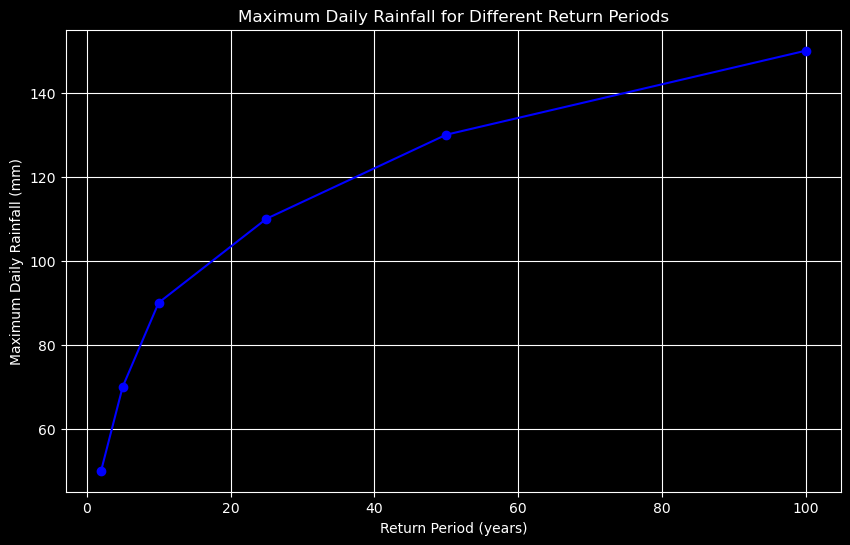

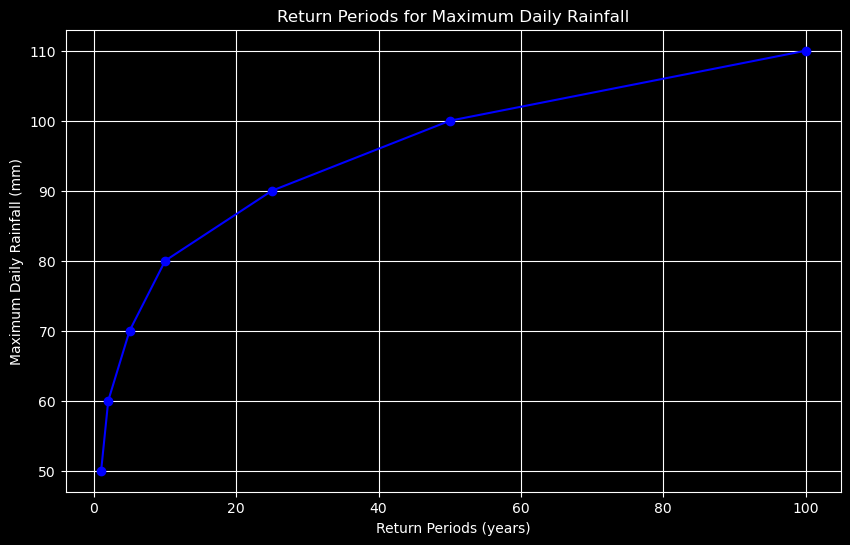

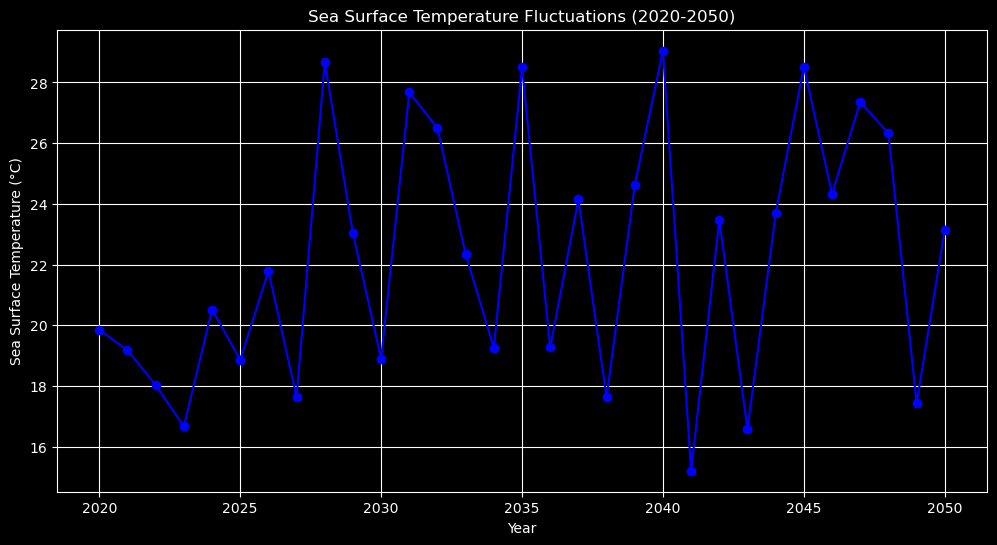

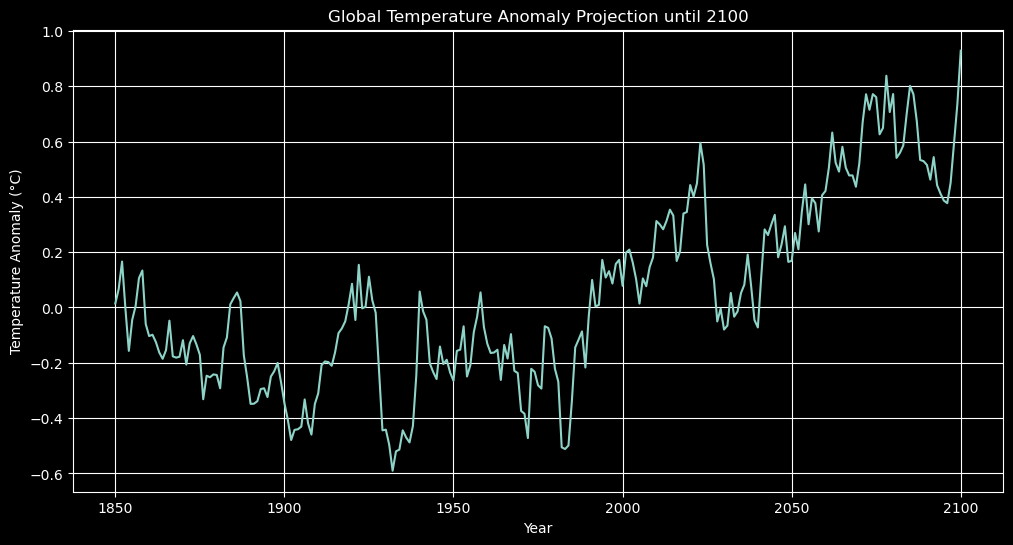

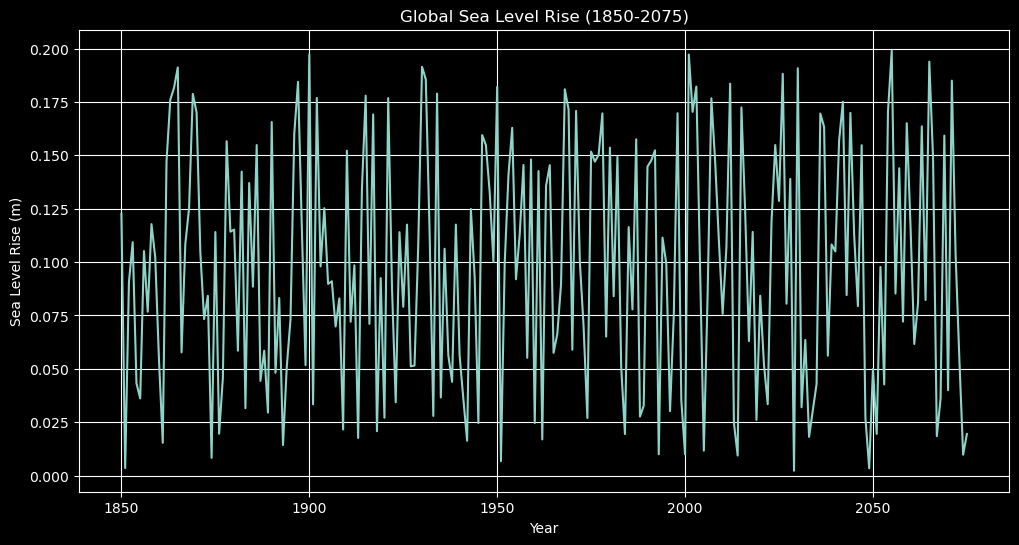

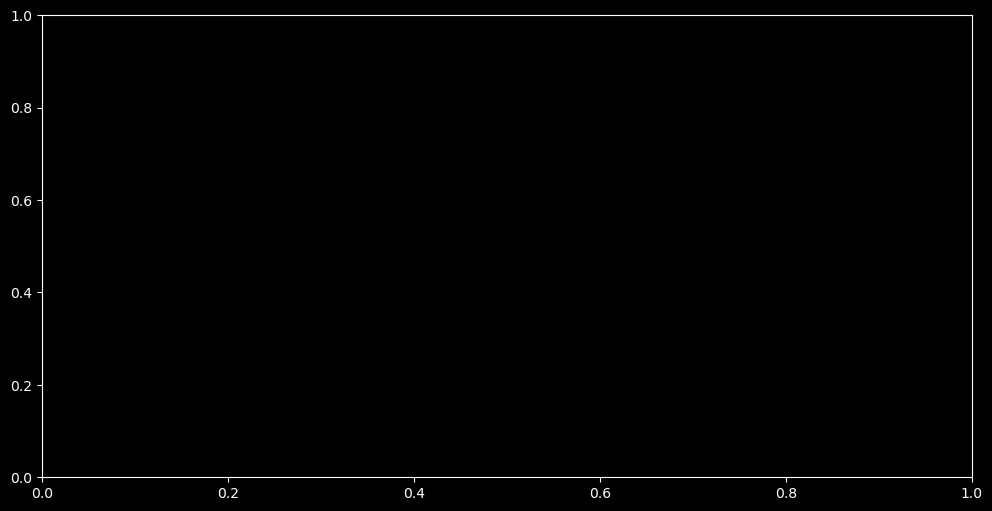

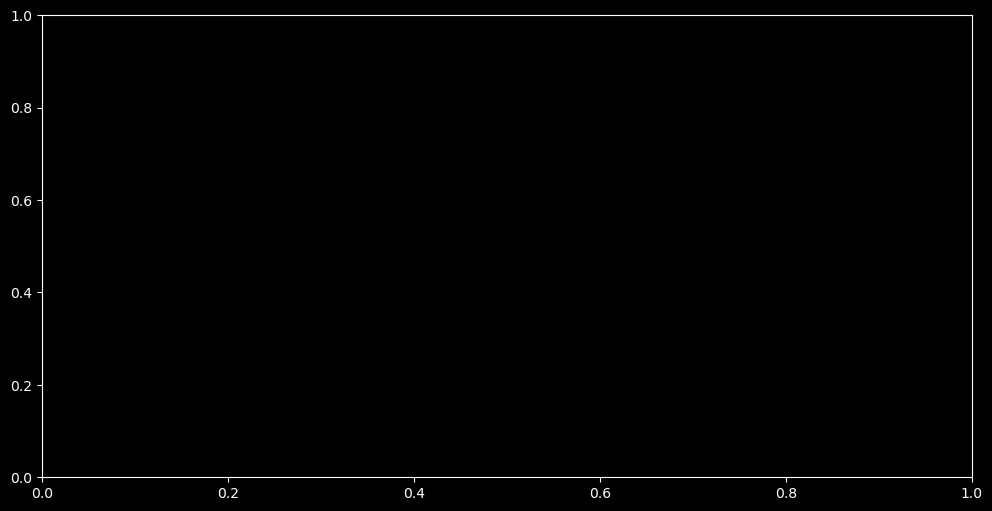

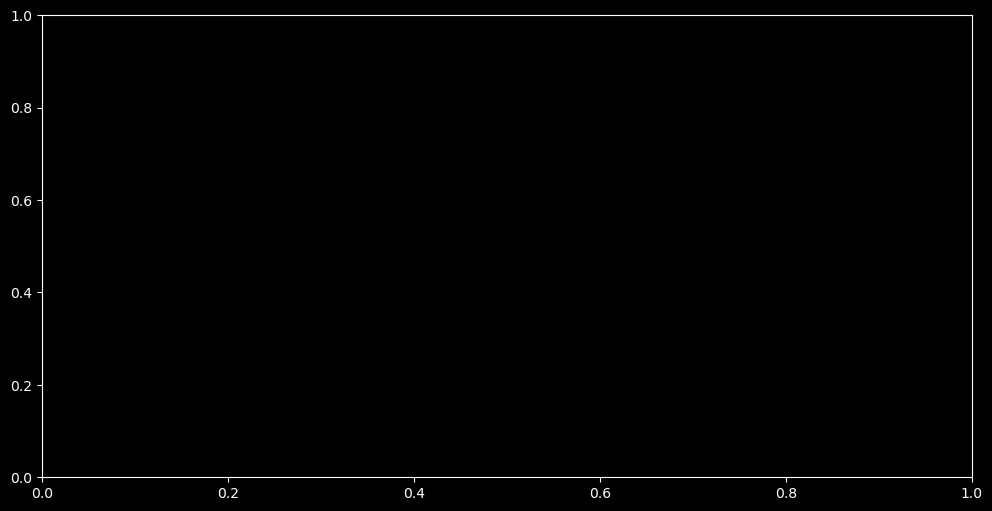

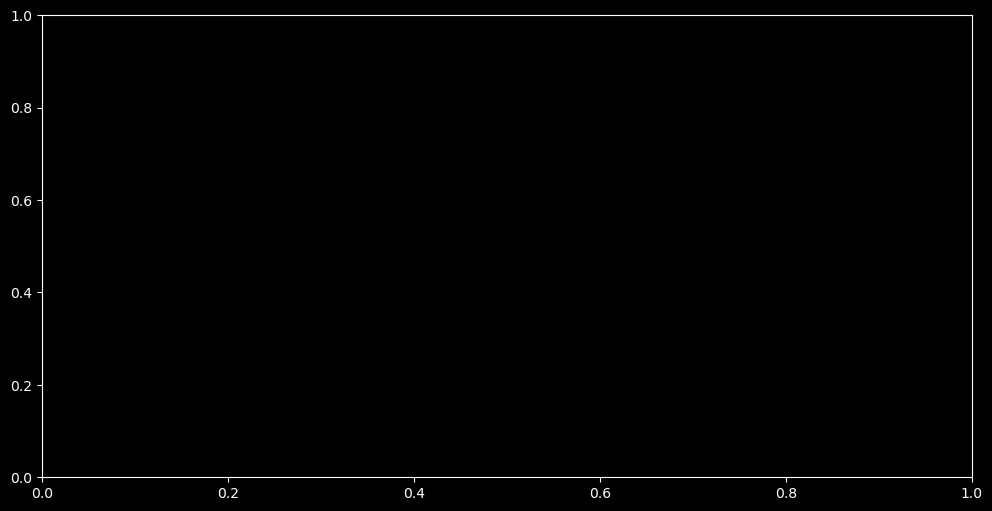

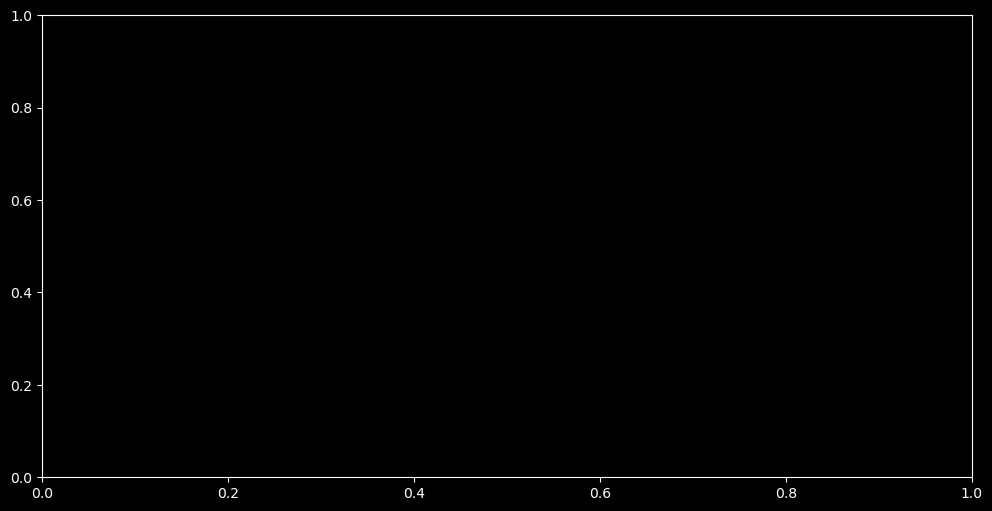

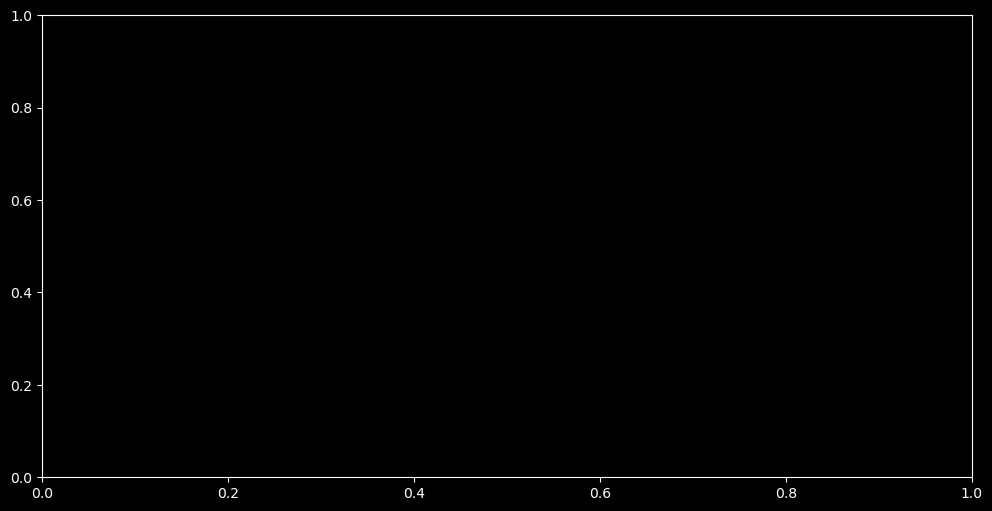

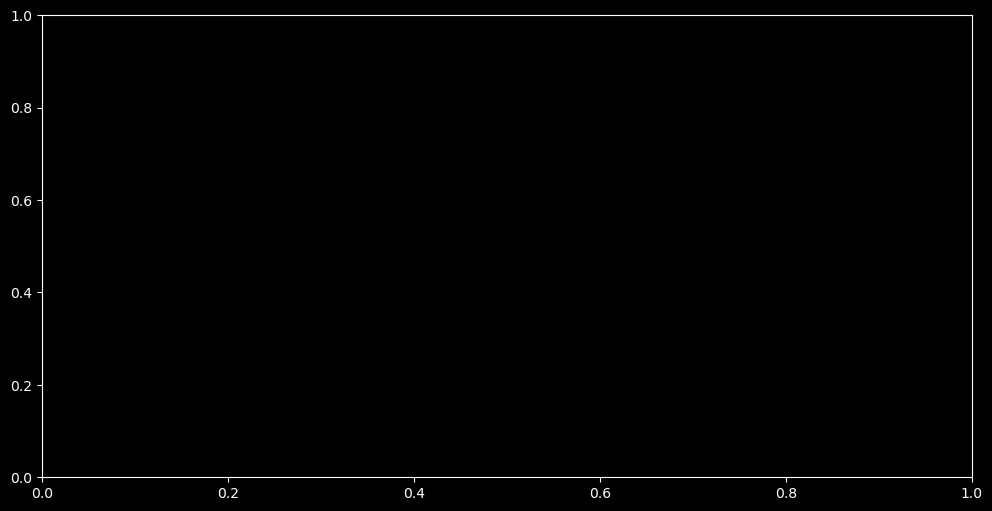

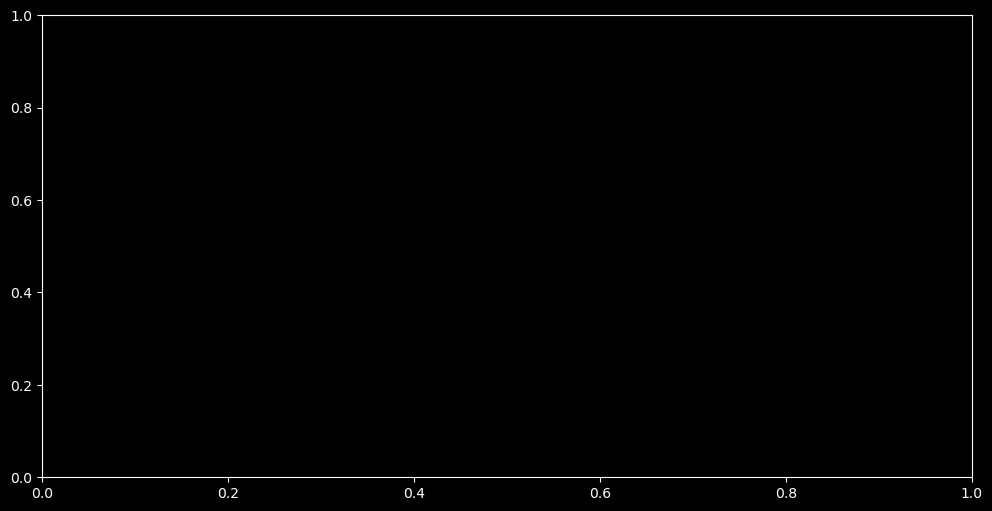

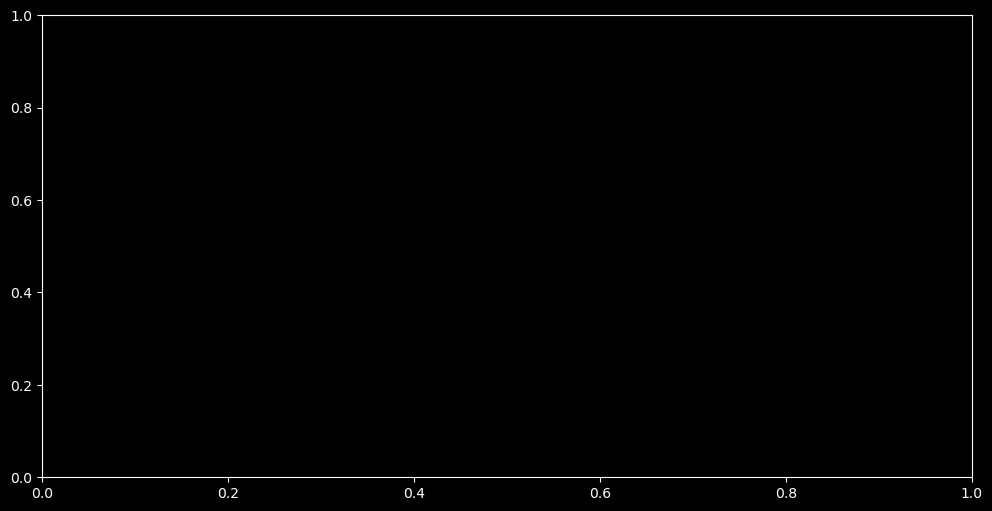

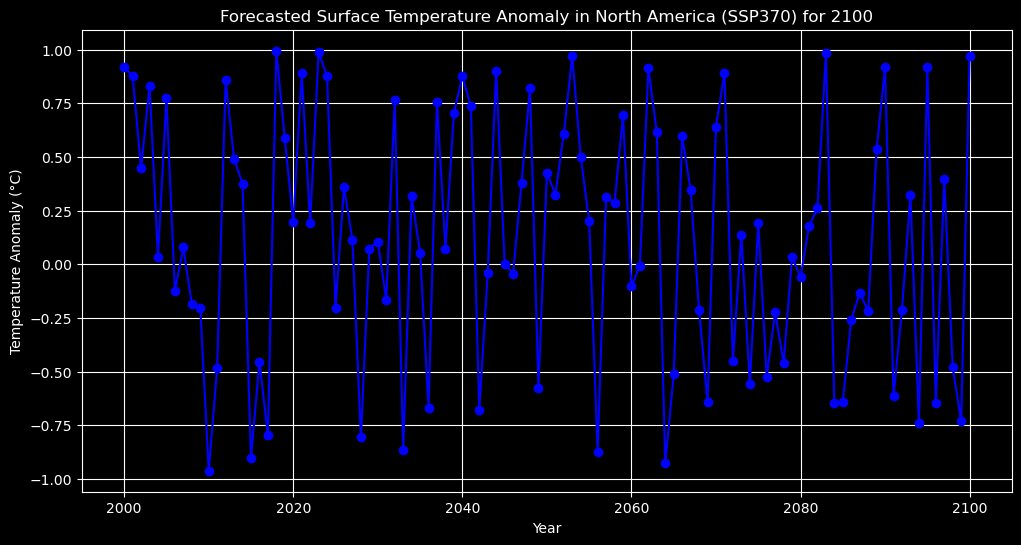

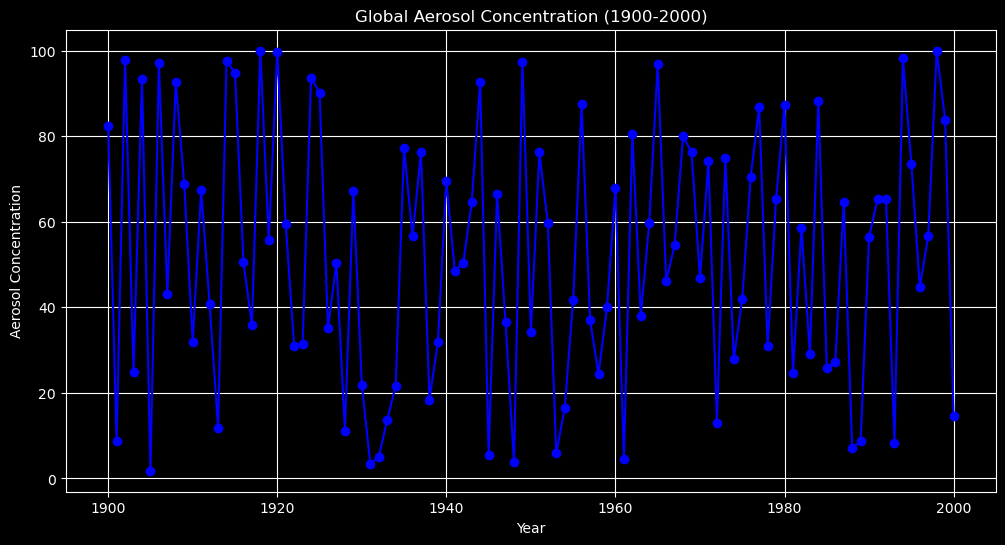

df var score 0.08571428571428569
emb var score 0.357142857142857
year 0.6428571428571411
resolution 0.12857142857142853
mip 0.14285714285714285
experiment 0.6333333333333322
semantic to preds {'variable': 0.9999999999999976, 'start year': 0.15714285714285717, 'end year': 0.35238095238095224, 'temporal resolution': 0.9380952380952359, 'experiment': 0.9952380952380928, 'MIP': 0.9999999999999976}
semantic+varagent to preds {'variable': 0.02380952380952381, 'start year': 0.6571428571428559, 'end year': 0.3714285714285712, 'temporal resolution': 0.9142857142857121, 'experiment': 0.9714285714285691, 'MIP': 0.9999999999999976}
dfagent to gold {'variable': 0.08571428571428569, 'start year': 0, 'end year': 0.057142857142857134, 'temporal resolution': 0.7714285714285698, 'experiment': 0.3999999999999997, 'MIP': 0.42857142857142816}
semantic to gold {'variable': 0.357142857142857, 'start year': 0.15714285714285717, 'end year': 0.35238095238095224, 'temporal resolution': 0.8142857142857125, 'exper

In [15]:
vardfscore = 0
varembscore = 0
yrscore = 0
resscore = 0
mipscore = 0
expscore = 0

predurlscore2 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics
predurlscore3 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics + varsdf agent

goldurlscore1 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #overall df pd agent
goldurlscore2 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics
goldurlscore3 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics + varsdf agent

for i, r in queries.iterrows():
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
    
    # VARIABLE
    try:
        var_agent = base_varpd.invoke(standalone)['output'] # pandas agent
    except:
        var_agent = None
    var_emb = find_relevant_variables(standalone).iloc[0]['variable'] # semantic/embeddings
    variablesgold = set(r['variable'].split(', ')) # true answer
    if var_agent in variablesgold or 'etc' in variablesgold:
        vardfscore += 1/len(queries)
    if var_emb in variablesgold or 'etc' in variablesgold:
        varembscore += 1/len(queries)
    
    # YEAR
    pred_startyr, pred_endyr = base_years(standalone)
    if r['start year'] <= pred_startyr:
        yrscore += 0.5/len(queries)
    if pred_endyr <= r['end year']:
        yrscore += 0.5/len(queries)
    
    # TEMPORAL RESOLUTION
    pred_reso = base_reso(standalone)
    if pred_reso == r['temporal resolution'] or (r.isna()['temporal resolution'] and pred_reso==None):
        resscore += 1/len(queries)
    
    # MIP
    pred_mip = base_mipf(standalone)
    if pred_mip == r['MIP'] or (pred_mip == None and r.isna()['MIP']):
        mipscore += 1/len(queries)
    
    # EXPERIMENT
    pred_exp = base_expf(standalone)
    if pred_exp == r['experiment'] or (pred_exp == None and r.isna()['experiment']):
        expscore += 1/len(queries)
    
    # CHOOSE DATASET
    # overall df
    chosen1 = base_datapd('plot average temperature of air')
    # grade the chosen dataset
    for descriptor_name in goldurlscore1:
        if descriptor_name == 'variable':
            if chosen1[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore1[descriptor_name] += 1/len(queries)
        else:
            if chosen1[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore1[descriptor_name] += 1/len(queries)
    
    # semantic
    preds = [('variable', var_emb), ('start year', pred_startyr), ('end year', pred_endyr),
             ('temporal resolution', pred_reso), ('experiment', pred_exp), ('MIP', pred_mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
    chosen2 = candidates.iloc[0,:]
    
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen2[descriptor_name] == descriptor_pred or descriptor_pred==None:
            predurlscore2[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen2[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore2[descriptor_name] += 1/len(queries)
        else:
            if chosen2[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore2[descriptor_name] += 1/len(queries)
    
    # semantic + varsdf agent
    preds = [('variable', var_agent), ('start year', pred_startyr), ('end year', pred_endyr),
             ('temporal resolution', pred_reso), ('experiment', pred_exp), ('MIP', pred_mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
    chosen3 = candidates.iloc[0,:]
    
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen3[descriptor_name] == descriptor_pred or descriptor_pred==None:
            predurlscore3[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen3[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore3[descriptor_name] += 1/len(queries)
        else:
            if chosen3[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore3[descriptor_name] += 1/len(queries)
                
print('df var score', vardfscore)
print('emb var score', varembscore)
print('year', yrscore)
print('resolution', resscore)
print('mip', mipscore)
print('experiment', expscore)

print("semantic to preds", predurlscore2)
print("semantic+varagent to preds", predurlscore3)

print("dfagent to gold", goldurlscore1)
print("semantic to gold", goldurlscore2)
print("semantic+varagent to gold", goldurlscore3)

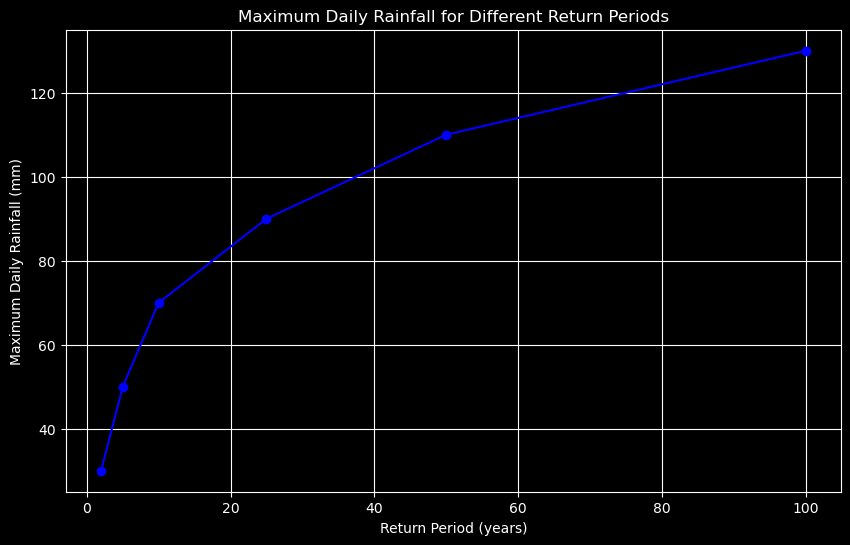

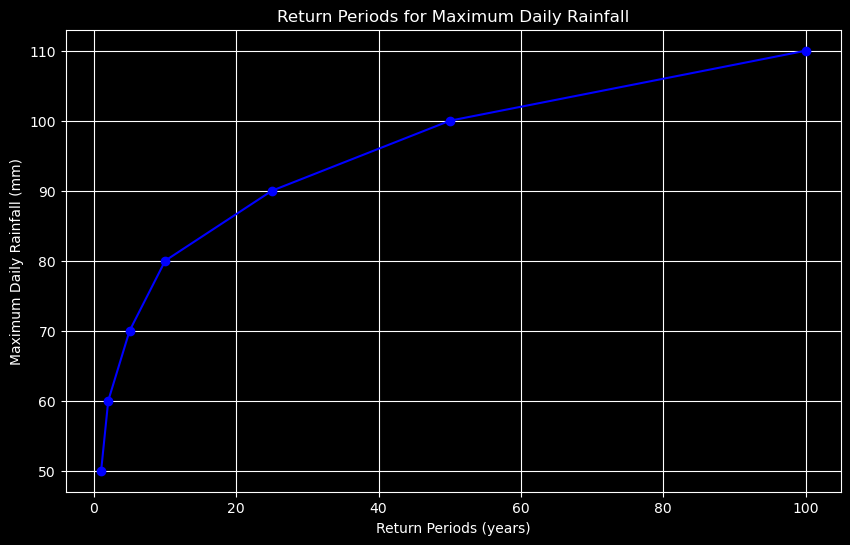

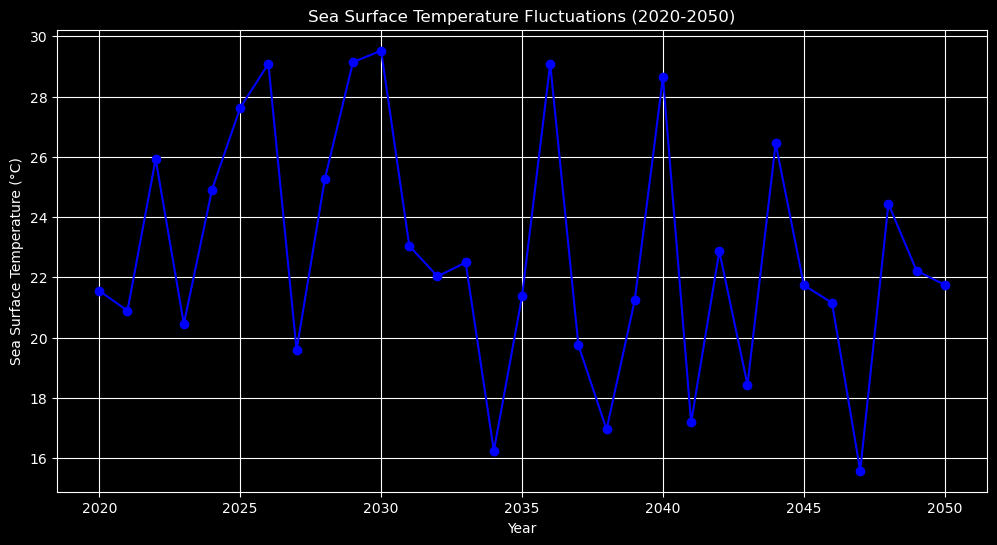

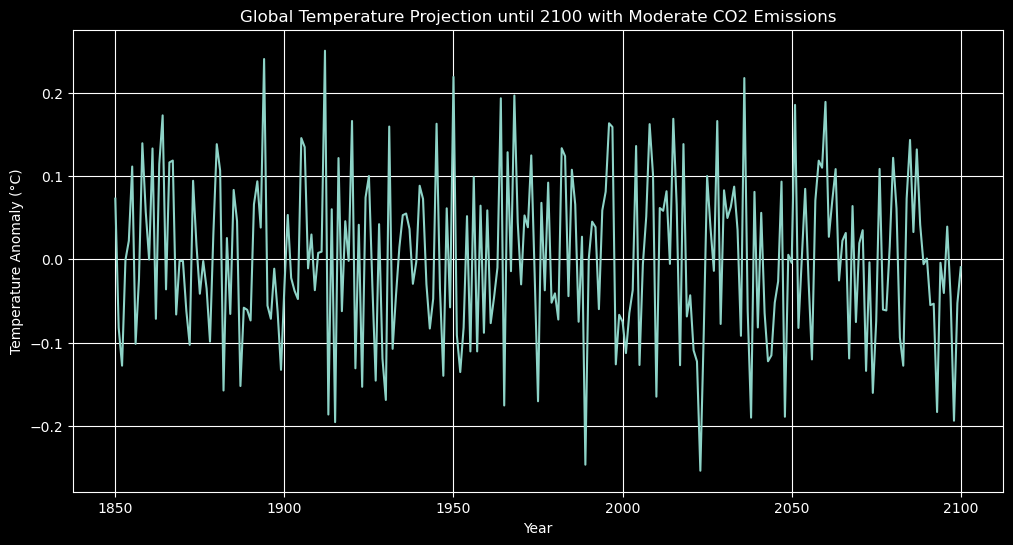

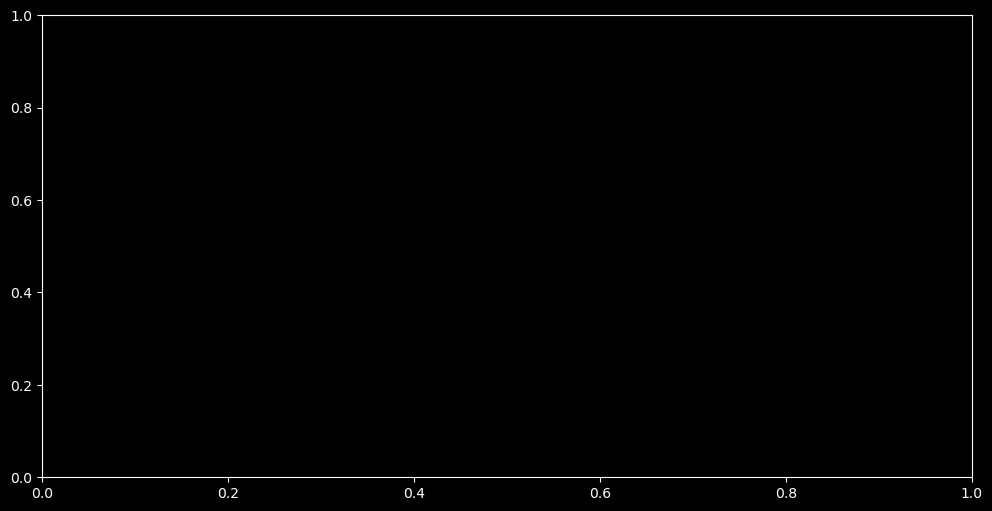

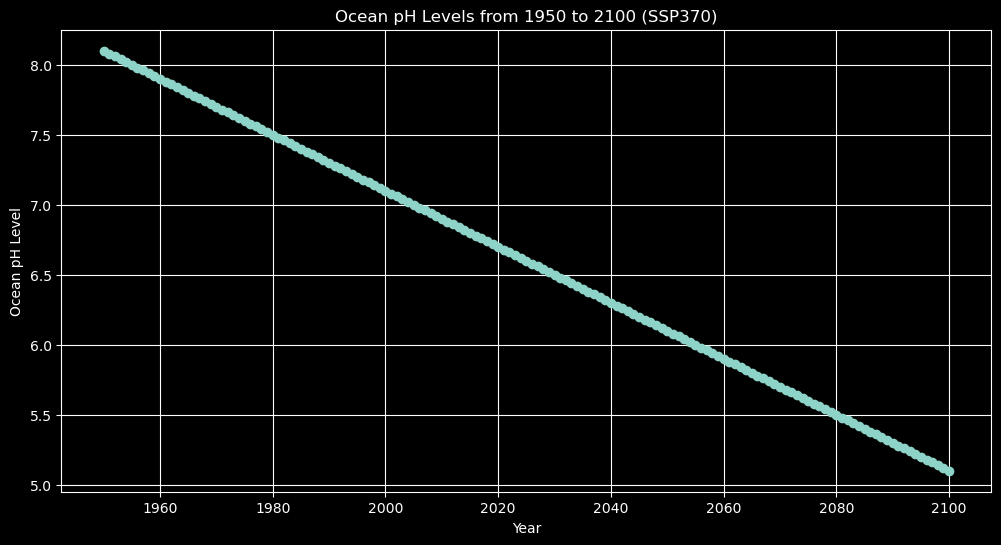

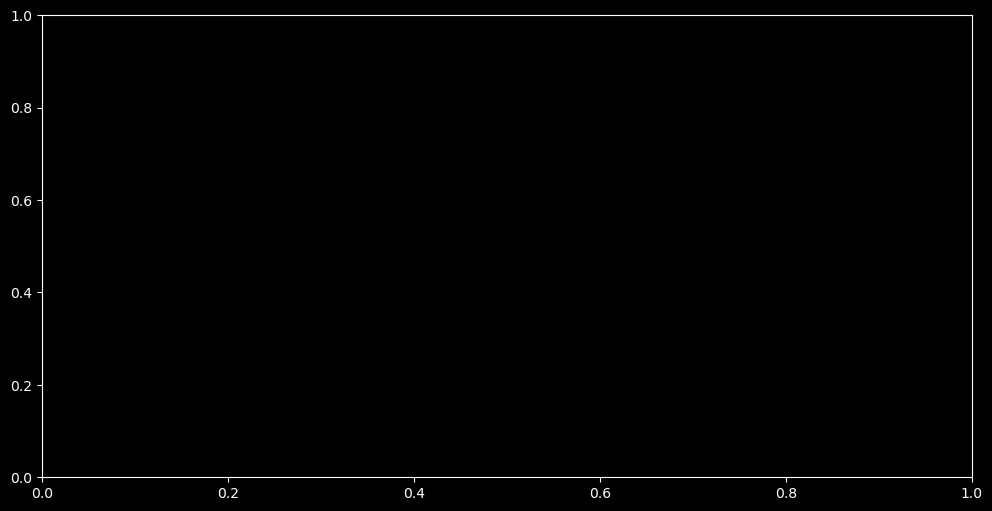

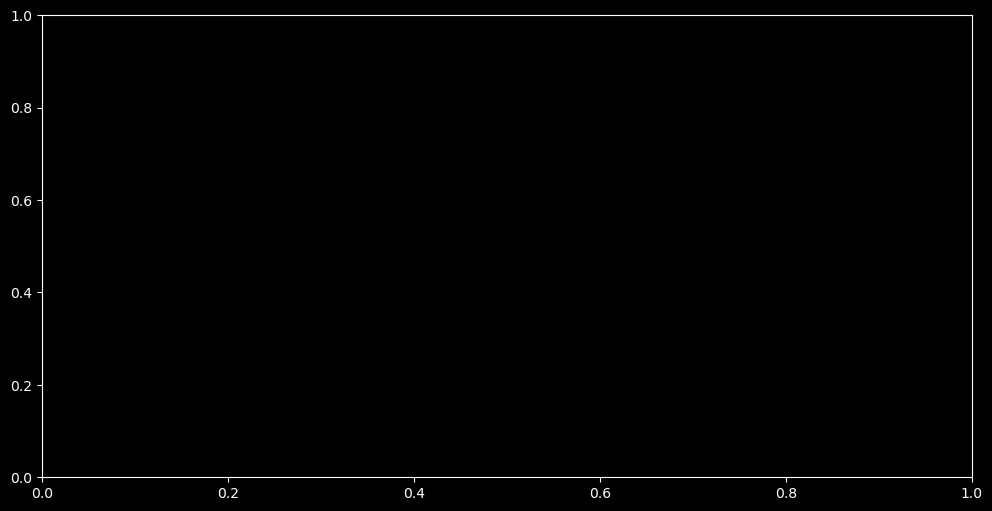

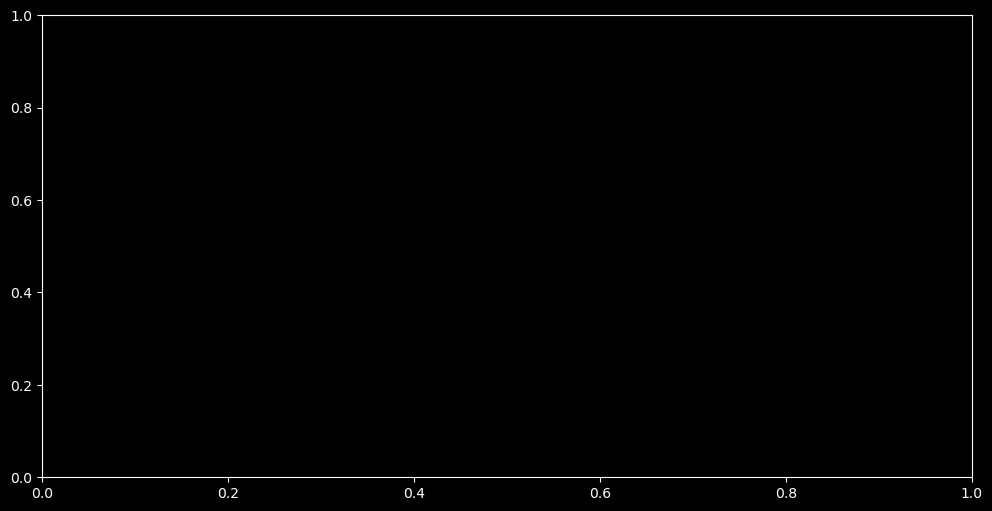

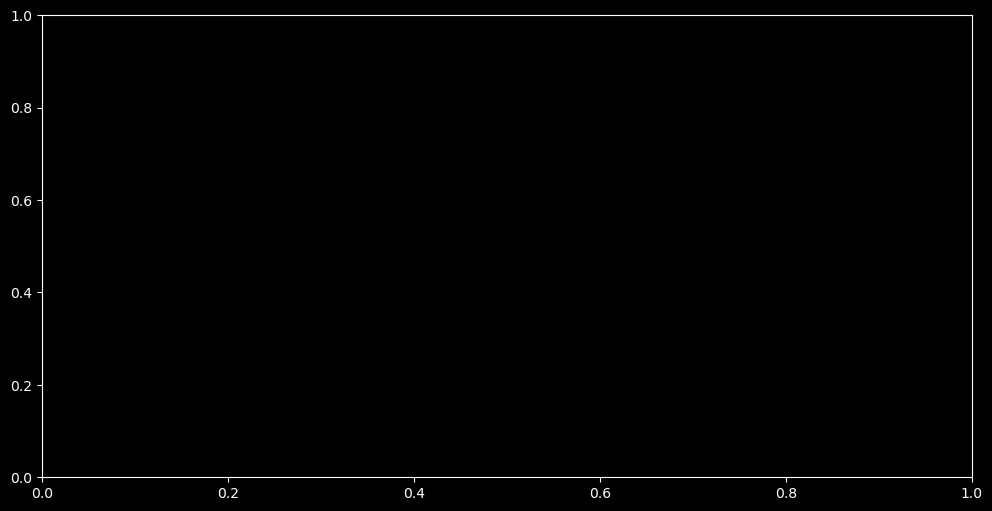

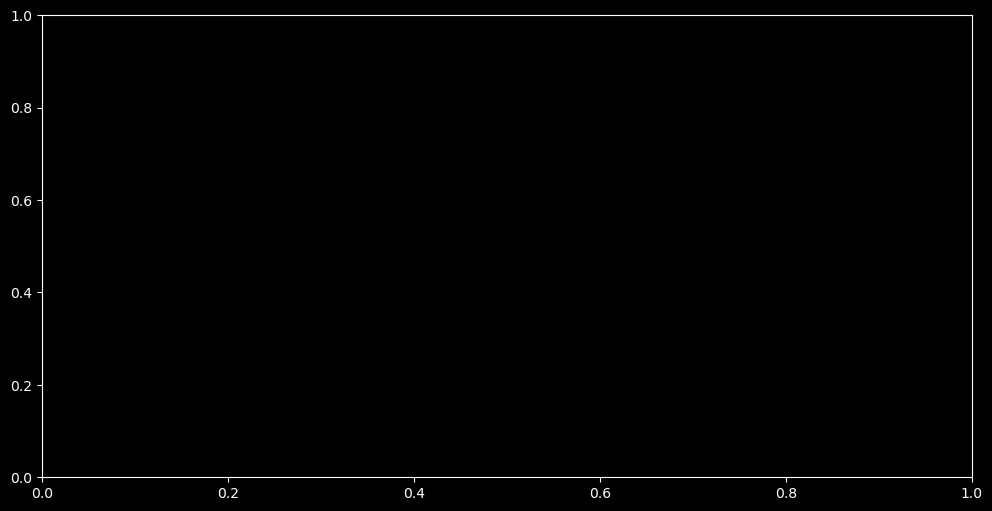

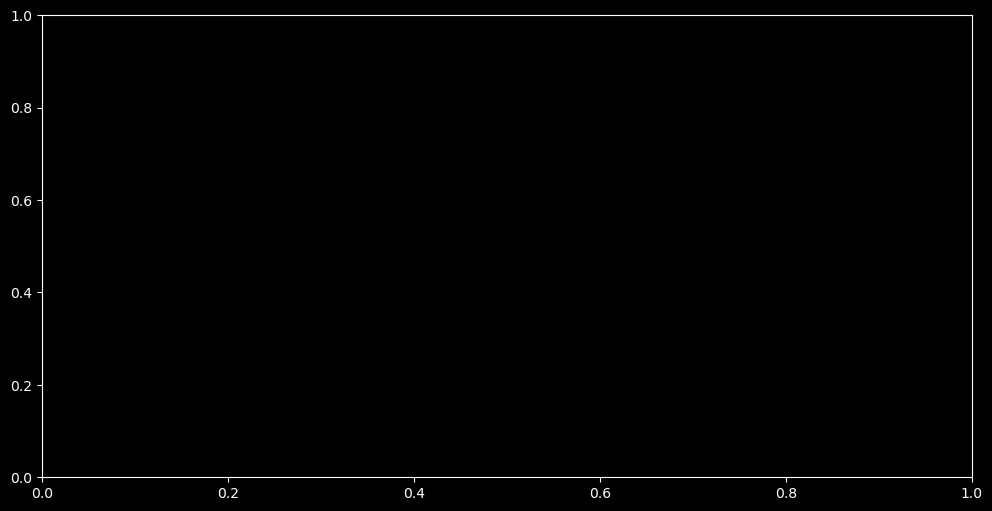

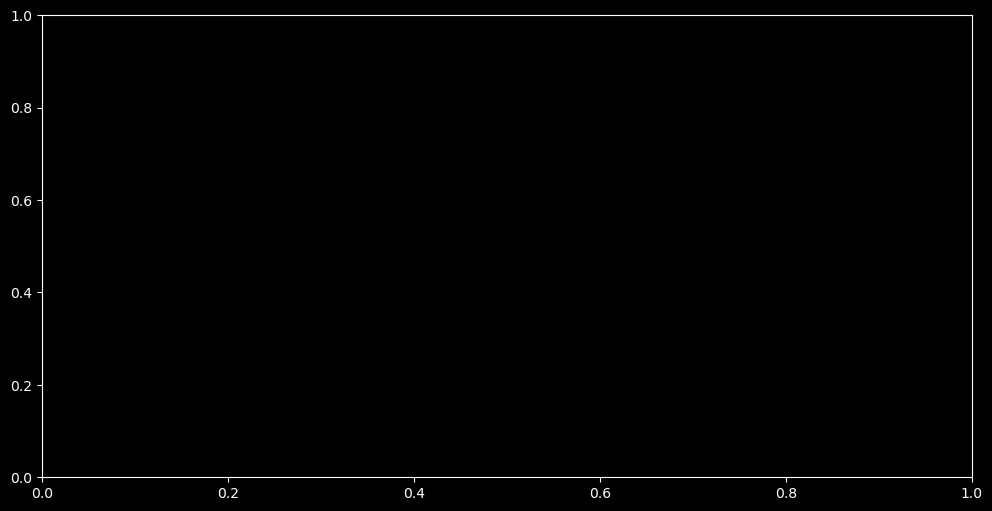

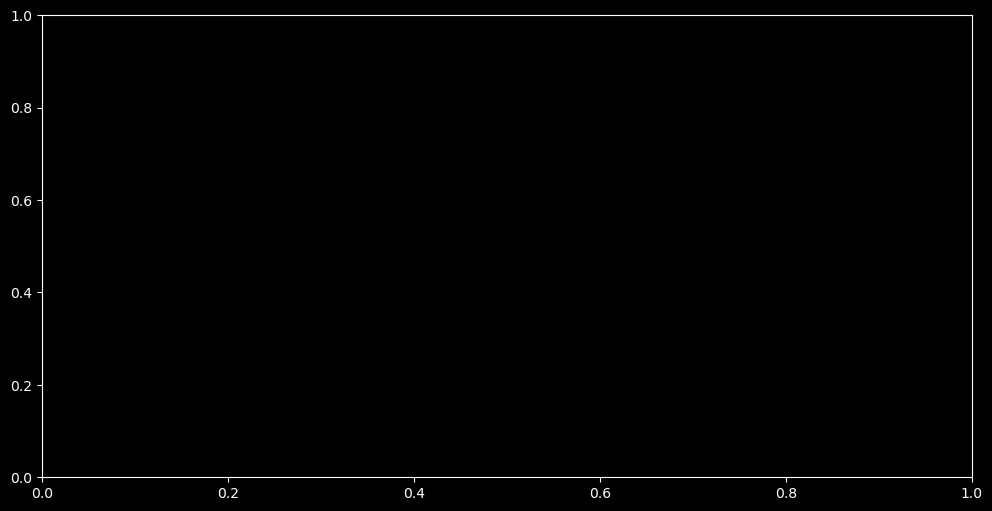

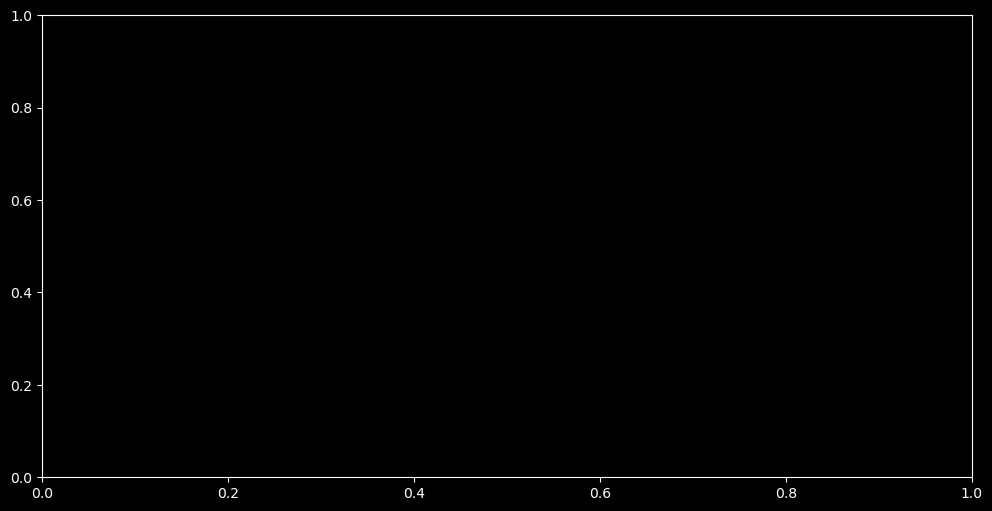

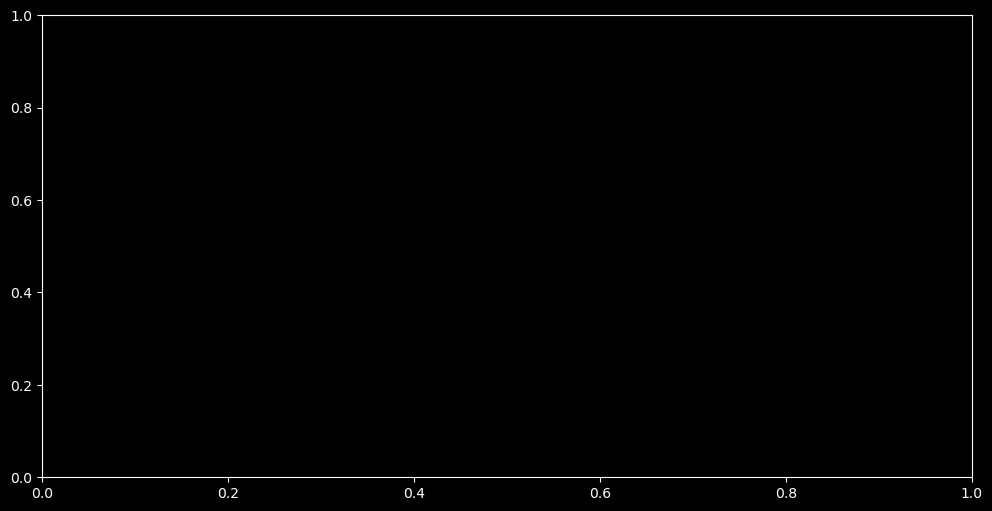

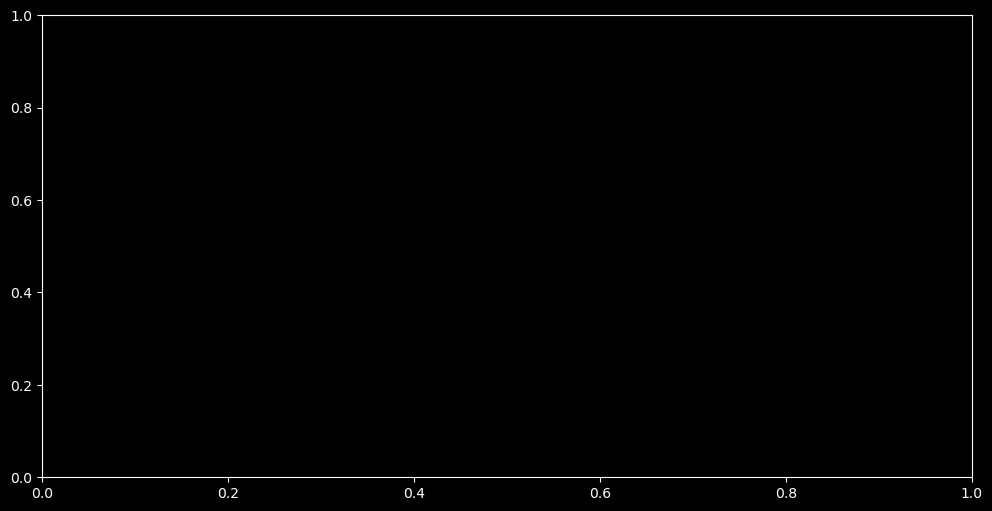

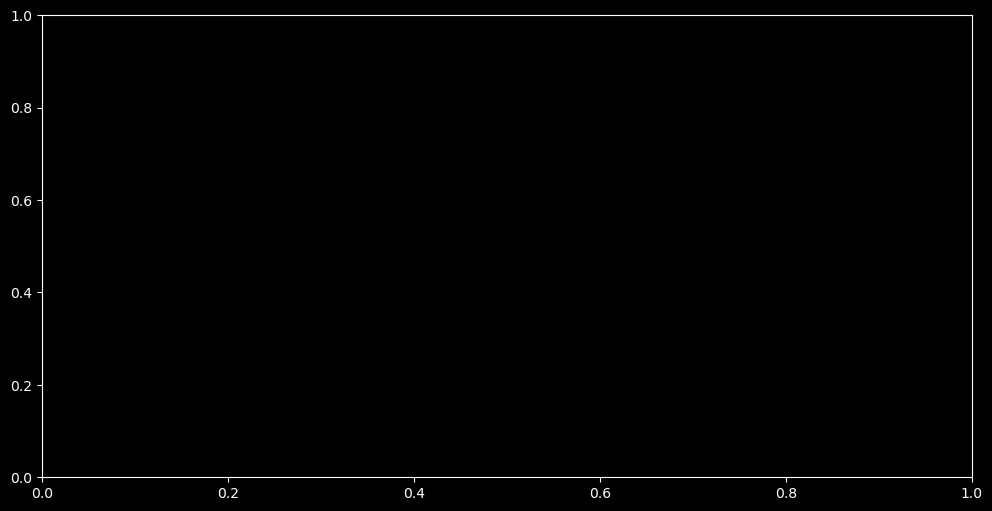

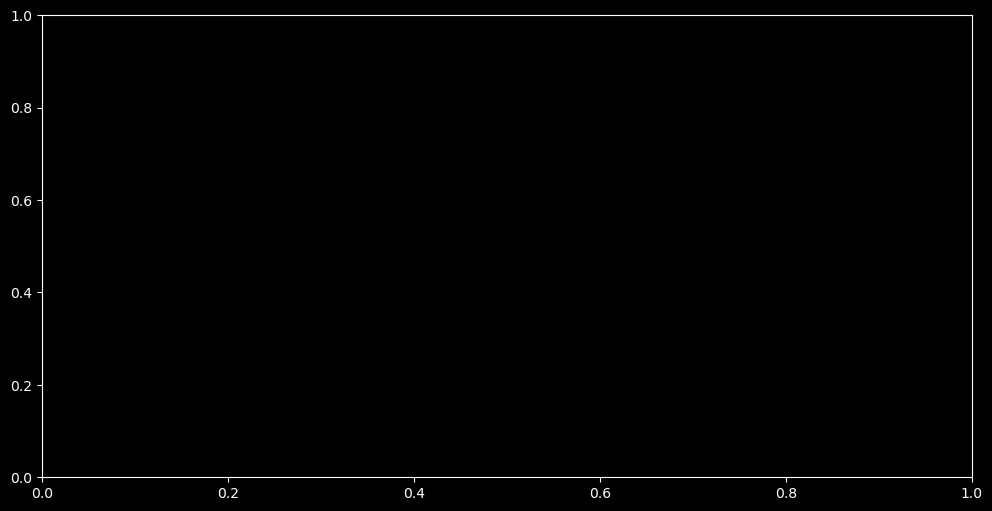

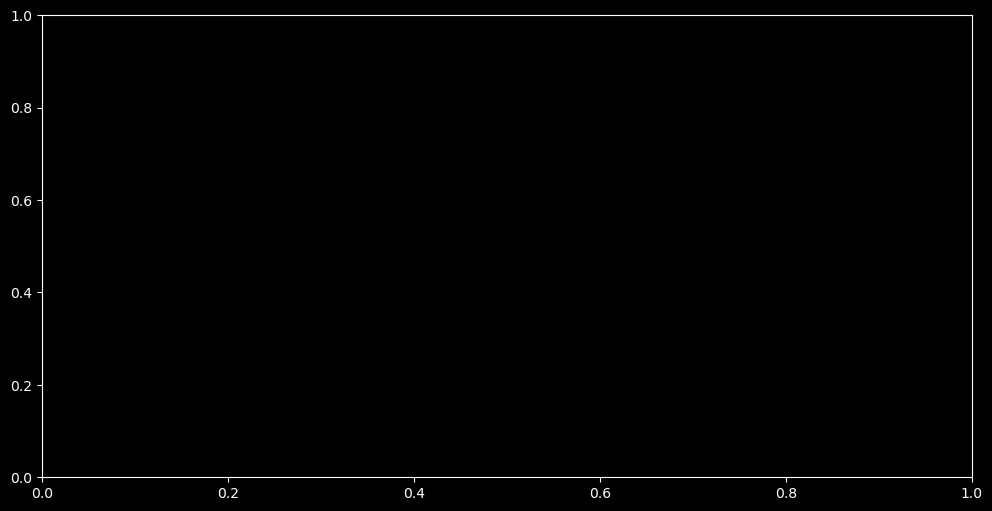

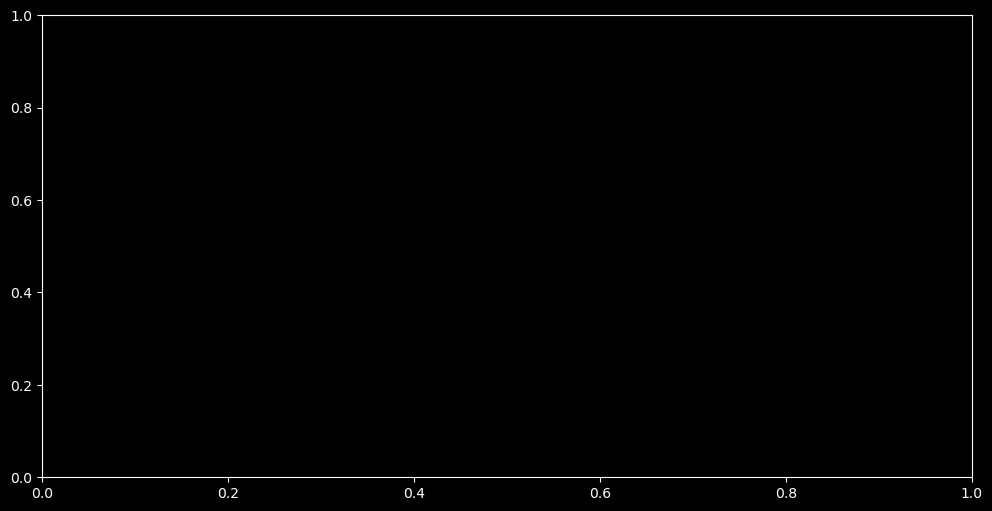

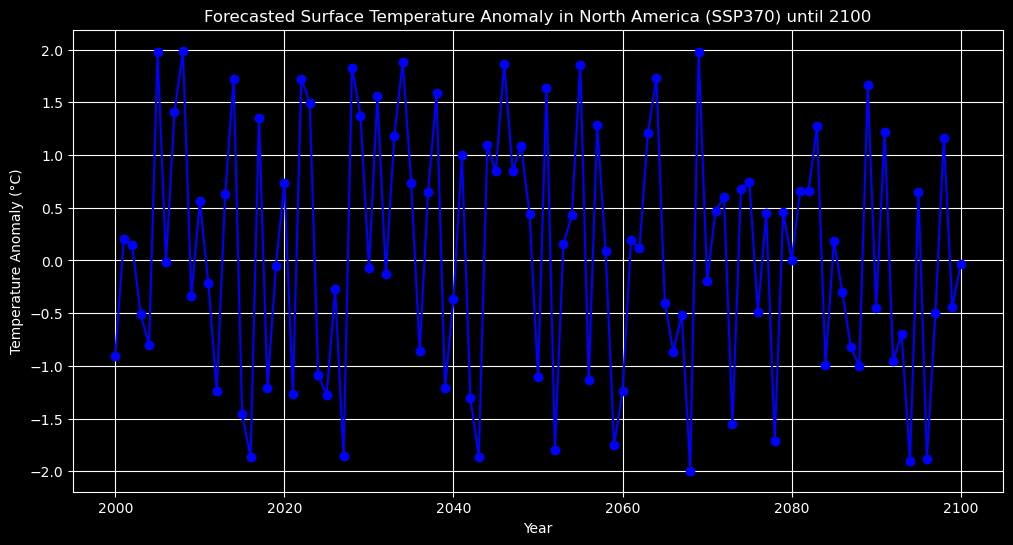

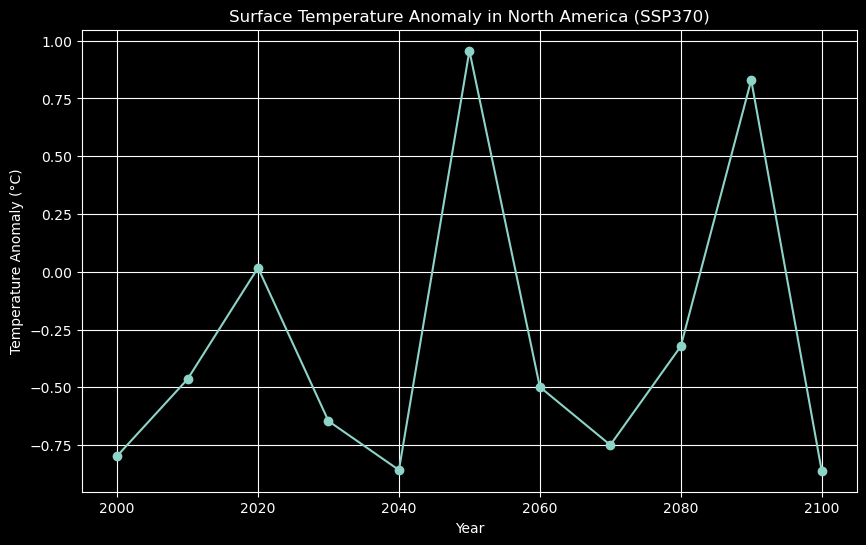

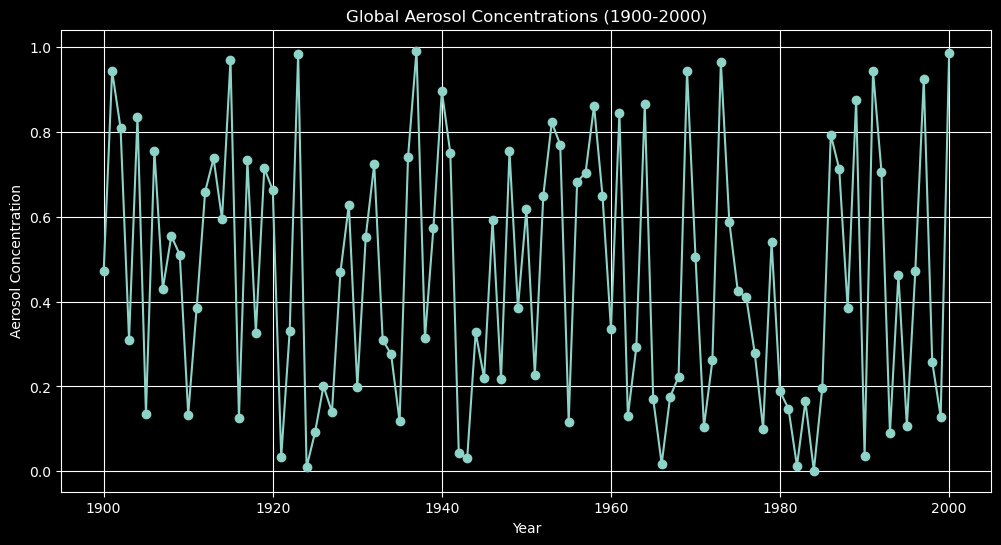

df var score 0.08571428571428569
emb var score 0.36190476190476173
year 0.6380952380952364
resolution 0.12857142857142853
mip 0.14285714285714285
experiment 0.6285714285714274
semantic to preds {'variable': 0.9999999999999976, 'start year': 0.16190476190476194, 'end year': 0.35238095238095224, 'temporal resolution': 0.9380952380952359, 'experiment': 0.9952380952380928, 'MIP': 0.9999999999999976}
semantic+varagent to preds {'variable': 0.052380952380952375, 'start year': 0.6523809523809512, 'end year': 0.3666666666666665, 'temporal resolution': 0.9142857142857121, 'experiment': 0.9714285714285691, 'MIP': 0.9999999999999976}
dfagent to gold {'variable': 0.08571428571428569, 'start year': 0, 'end year': 0.057142857142857134, 'temporal resolution': 0.7714285714285698, 'experiment': 0.3999999999999997, 'MIP': 0.42857142857142816}
semantic to gold {'variable': 0.36190476190476173, 'start year': 0.16190476190476194, 'end year': 0.35238095238095224, 'temporal resolution': 0.8095238095238078, '

In [16]:
vardfscore = 0
varembscore = 0
yrscore = 0
resscore = 0
mipscore = 0
expscore = 0

predurlscore2 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics
predurlscore3 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics + varsdf agent

goldurlscore1 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #overall df pd agent
goldurlscore2 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics
goldurlscore3 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics + varsdf agent

for i, r in queries.iterrows():
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
    
    # VARIABLE
    try:
        var_agent = base_varpd.invoke(standalone)['output'] # pandas agent
    except:
        var_agent = None
    var_emb = find_relevant_variables(standalone).iloc[0]['variable'] # semantic/embeddings
    variablesgold = set(r['variable'].split(', ')) # true answer
    if var_agent in variablesgold or 'etc' in variablesgold:
        vardfscore += 1/len(queries)
    if var_emb in variablesgold or 'etc' in variablesgold:
        varembscore += 1/len(queries)
    
    # YEAR
    pred_startyr, pred_endyr = base_years(standalone)
    if r['start year'] <= pred_startyr:
        yrscore += 0.5/len(queries)
    if pred_endyr <= r['end year']:
        yrscore += 0.5/len(queries)
    
    # TEMPORAL RESOLUTION
    pred_reso = base_reso(standalone)
    if pred_reso == r['temporal resolution'] or (r.isna()['temporal resolution'] and pred_reso==None):
        resscore += 1/len(queries)
    
    # MIP
    pred_mip = base_mipf(standalone)
    if pred_mip == r['MIP'] or (pred_mip == None and r.isna()['MIP']):
        mipscore += 1/len(queries)
    
    # EXPERIMENT
    pred_exp = base_expf(standalone)
    if pred_exp == r['experiment'] or (pred_exp == None and r.isna()['experiment']):
        expscore += 1/len(queries)
    
    # CHOOSE DATASET
    # overall df
    chosen1 = base_datapd('plot average temperature of air')
    # grade the chosen dataset
    for descriptor_name in goldurlscore1:
        if descriptor_name == 'variable':
            if chosen1[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore1[descriptor_name] += 1/len(queries)
        else:
            if chosen1[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore1[descriptor_name] += 1/len(queries)
    
    # semantic
    preds = [('variable', var_emb), ('start year', pred_startyr), ('end year', pred_endyr),
             ('temporal resolution', pred_reso), ('experiment', pred_exp), ('MIP', pred_mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
    chosen2 = candidates.iloc[0,:]
    
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen2[descriptor_name] == descriptor_pred or descriptor_pred==None:
            predurlscore2[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen2[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore2[descriptor_name] += 1/len(queries)
        else:
            if chosen2[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore2[descriptor_name] += 1/len(queries)
    
    # semantic + varsdf agent
    preds = [('variable', var_agent), ('start year', pred_startyr), ('end year', pred_endyr),
             ('temporal resolution', pred_reso), ('experiment', pred_exp), ('MIP', pred_mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
    chosen3 = candidates.iloc[0,:]
    
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen3[descriptor_name] == descriptor_pred or descriptor_pred==None:
            predurlscore3[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen3[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore3[descriptor_name] += 1/len(queries)
        else:
            if chosen3[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore3[descriptor_name] += 1/len(queries)
                
print('df var score', vardfscore)
print('emb var score', varembscore)
print('year', yrscore)
print('resolution', resscore)
print('mip', mipscore)
print('experiment', expscore)

print("semantic to preds", predurlscore2)
print("semantic+varagent to preds", predurlscore3)

print("dfagent to gold", goldurlscore1)
print("semantic to gold", goldurlscore2)
print("semantic+varagent to gold", goldurlscore3)

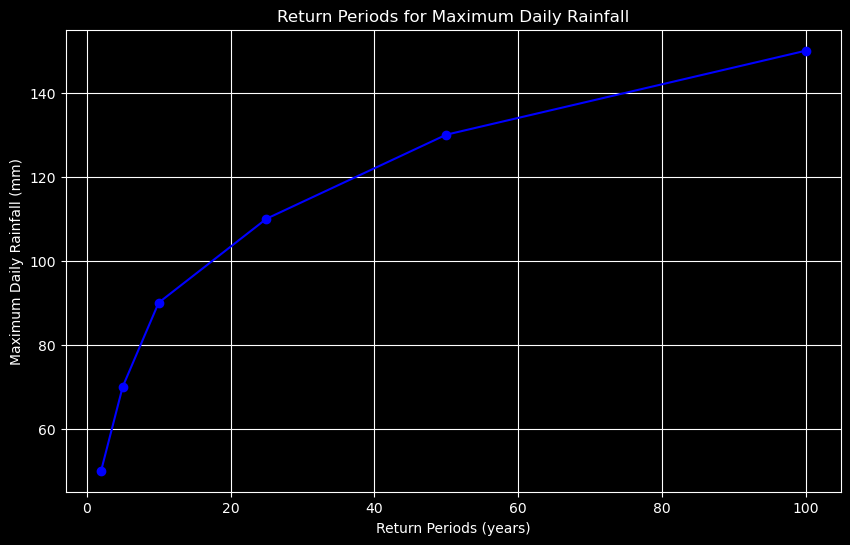

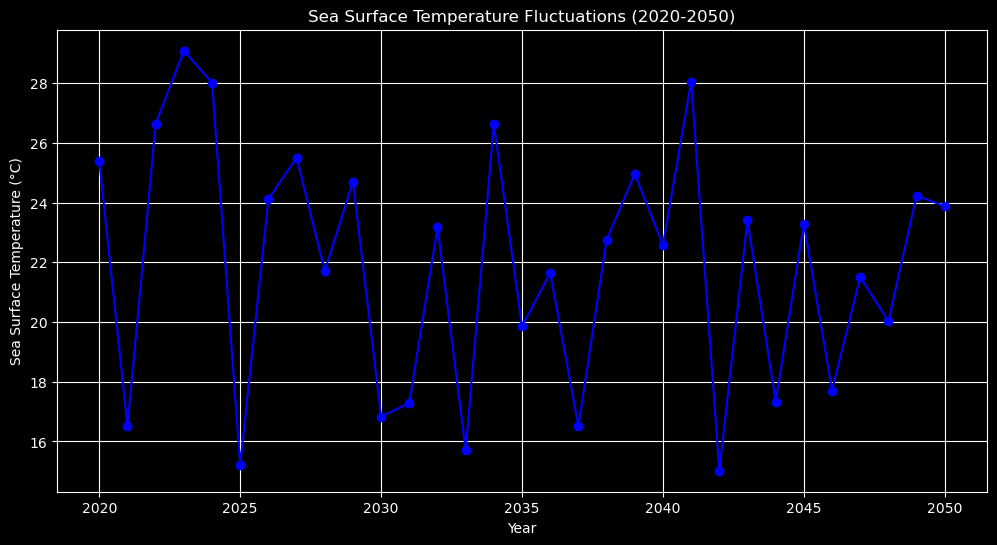

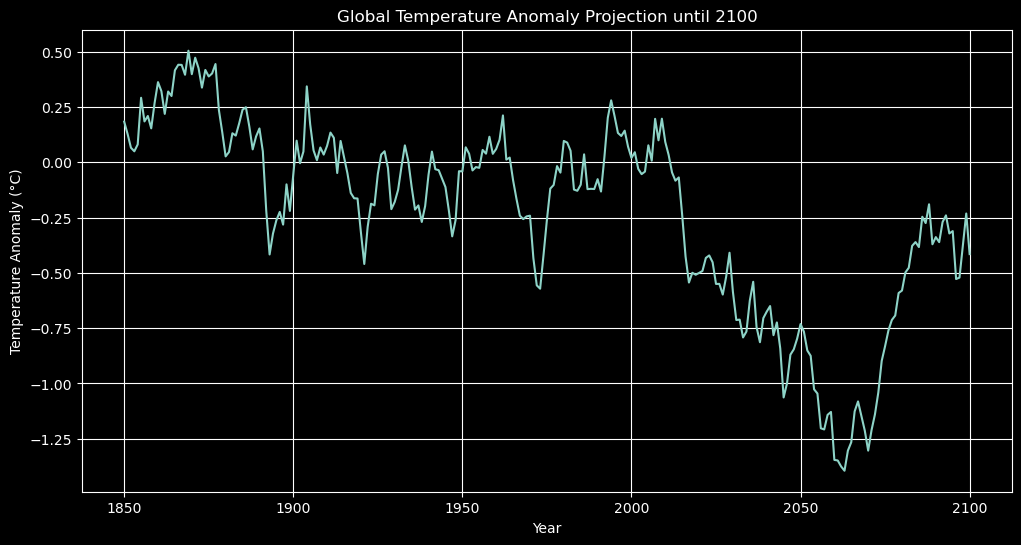

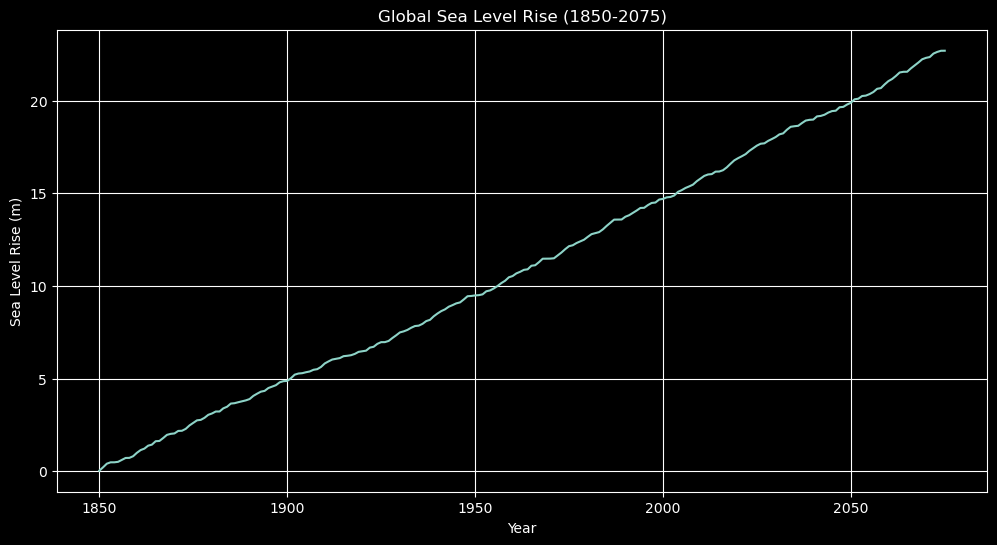

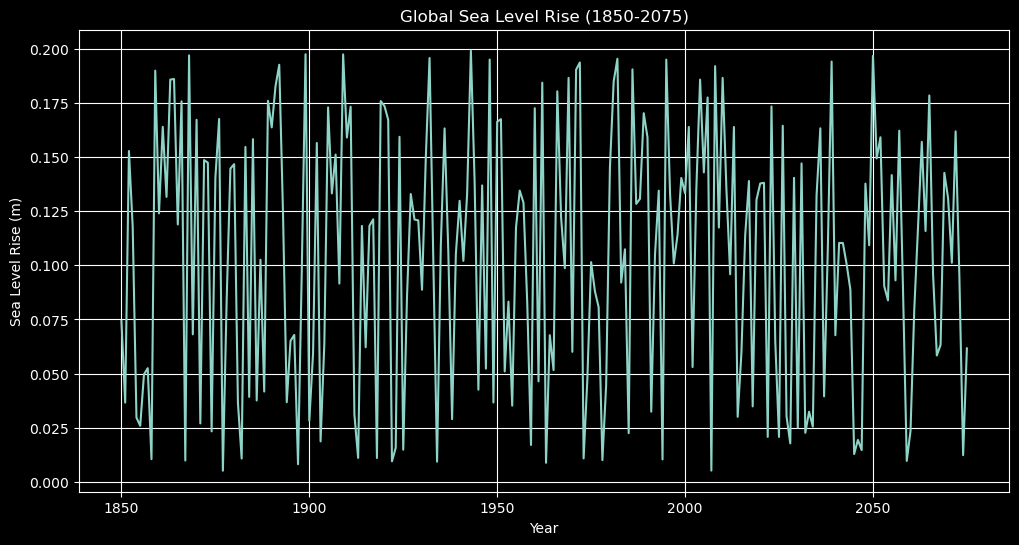

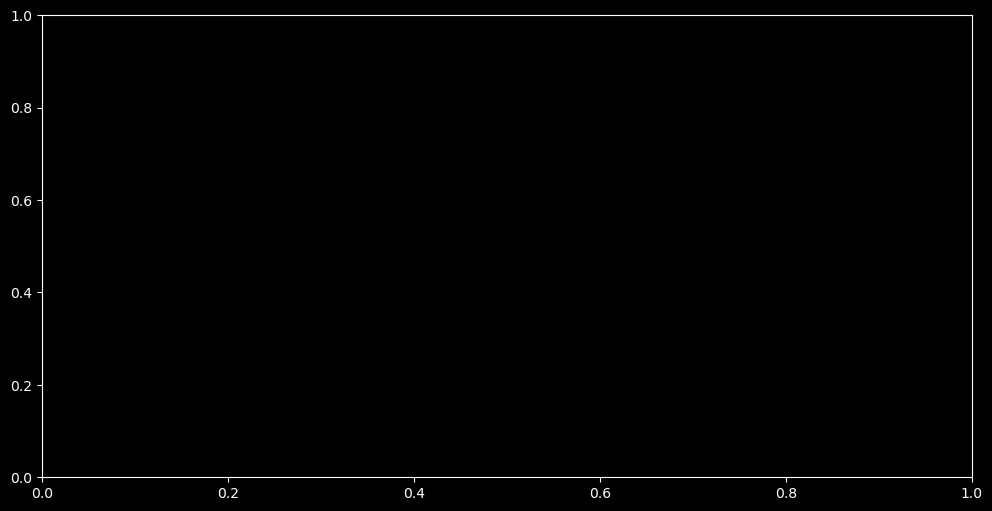

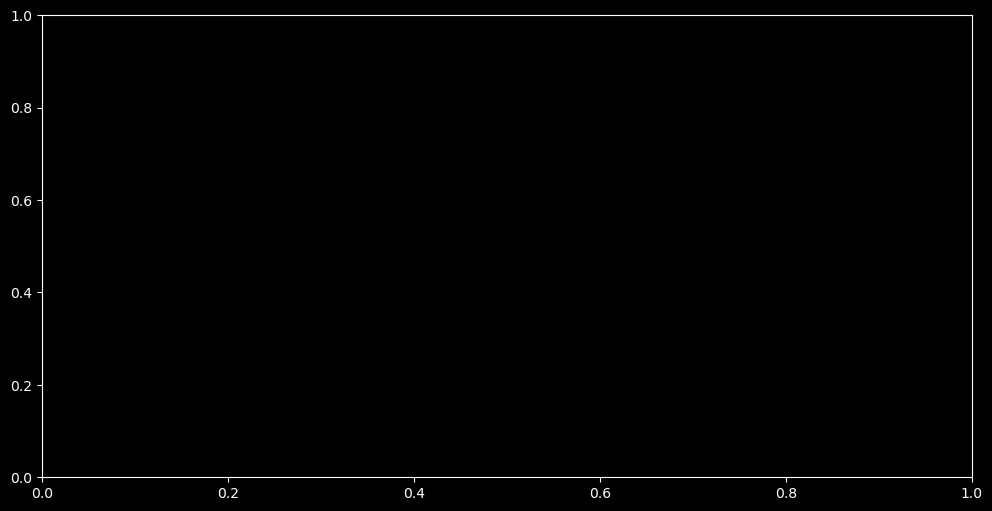

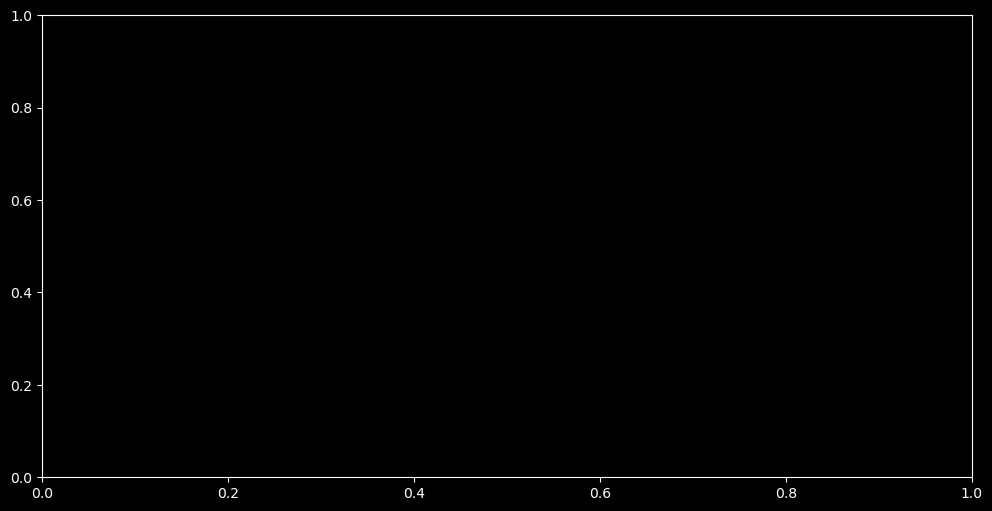

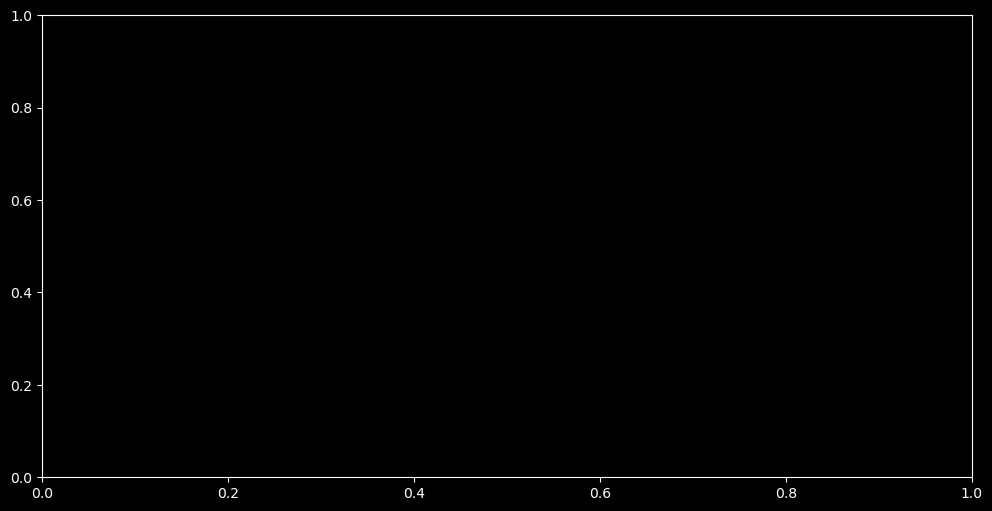

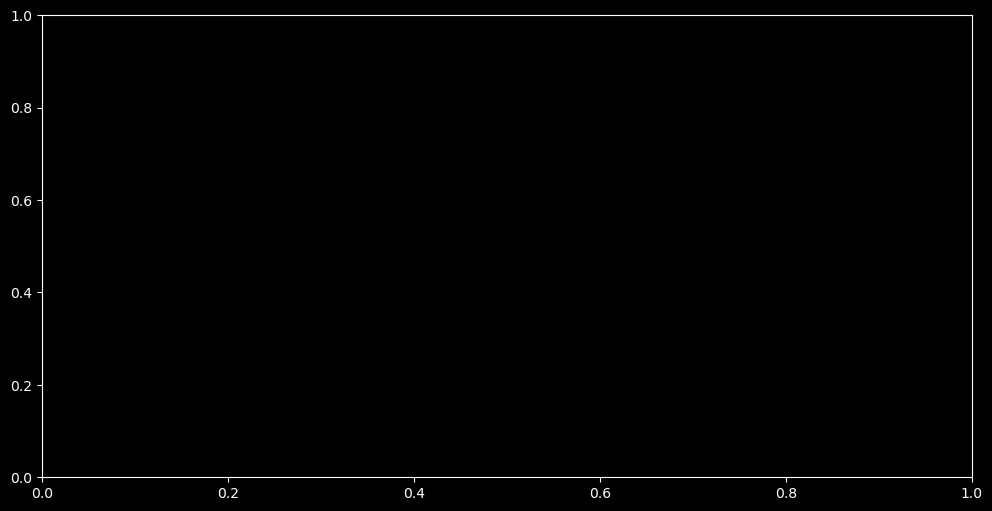

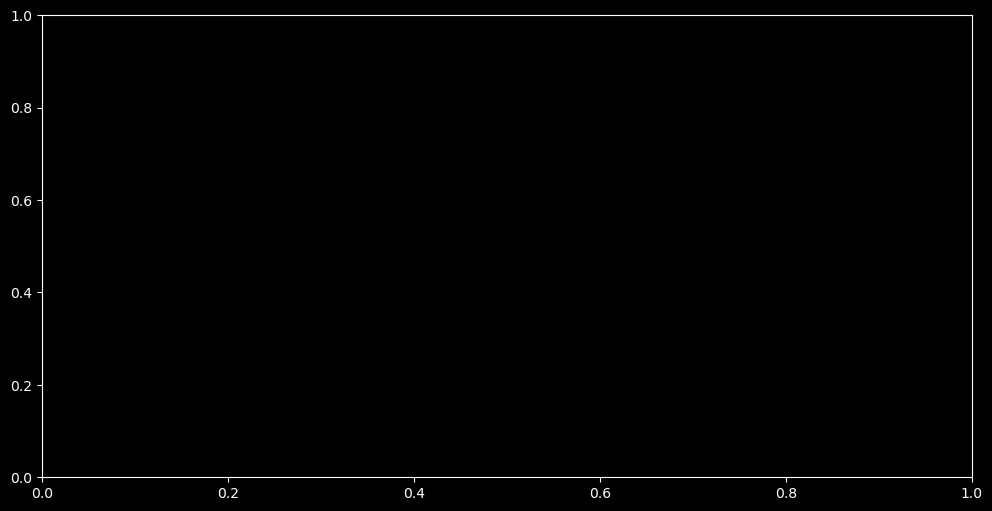

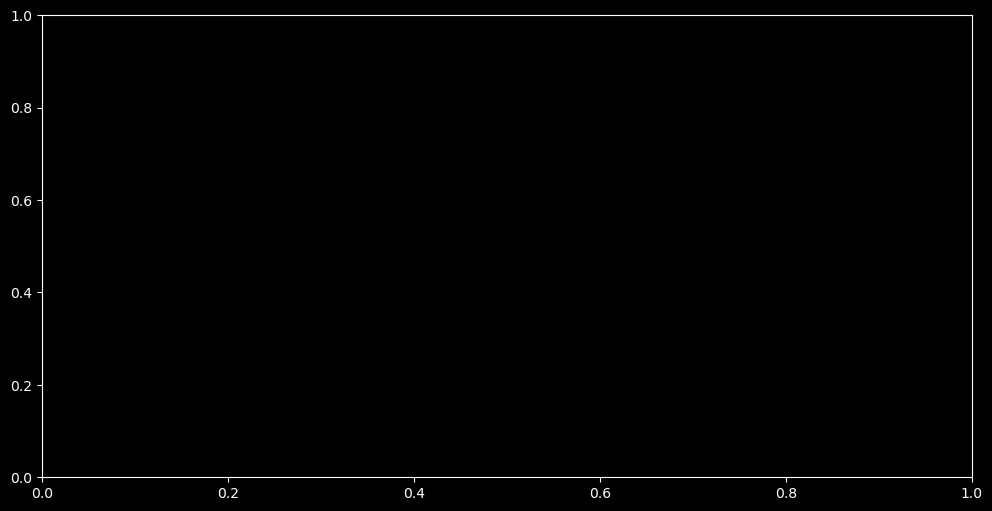

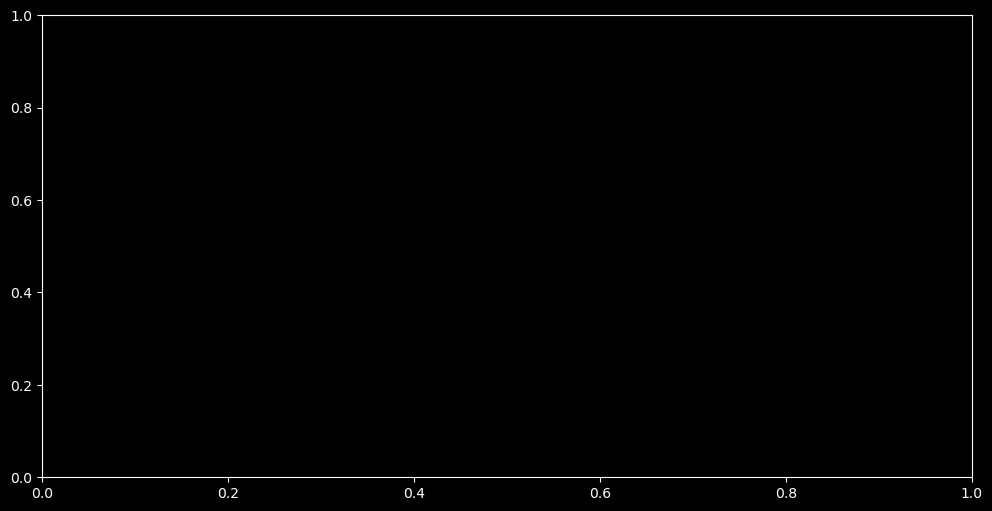

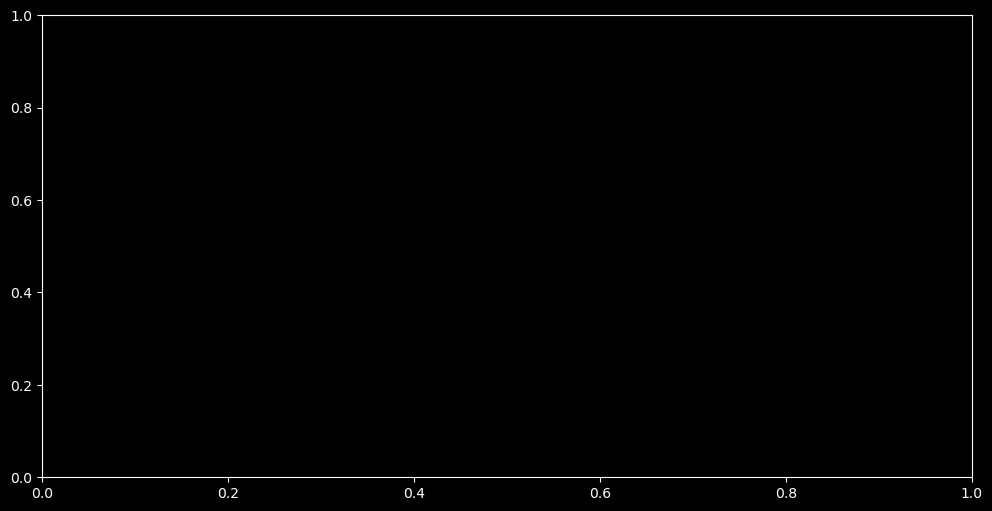

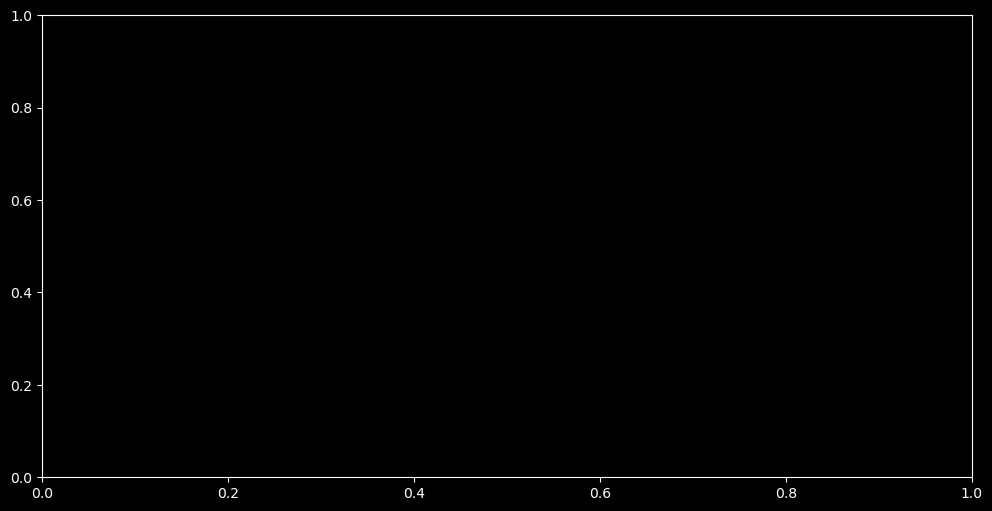

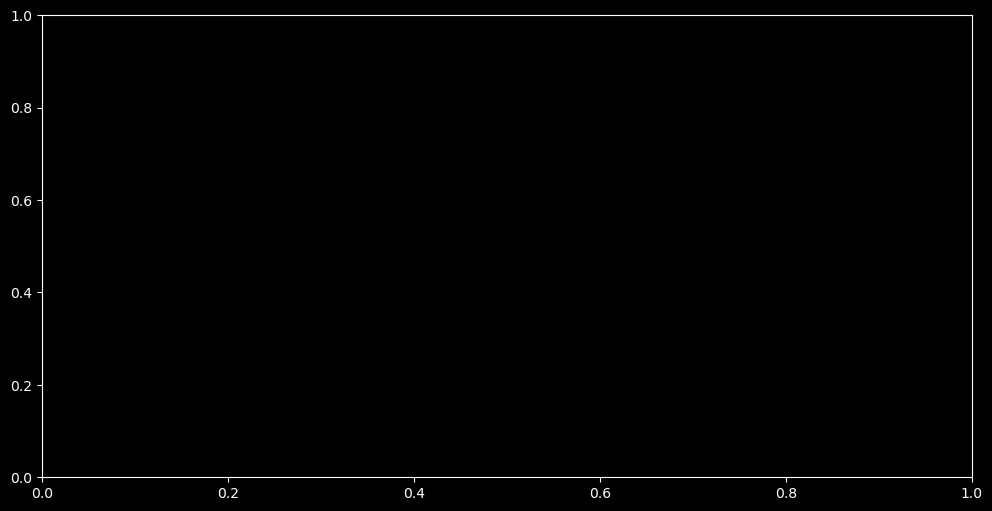

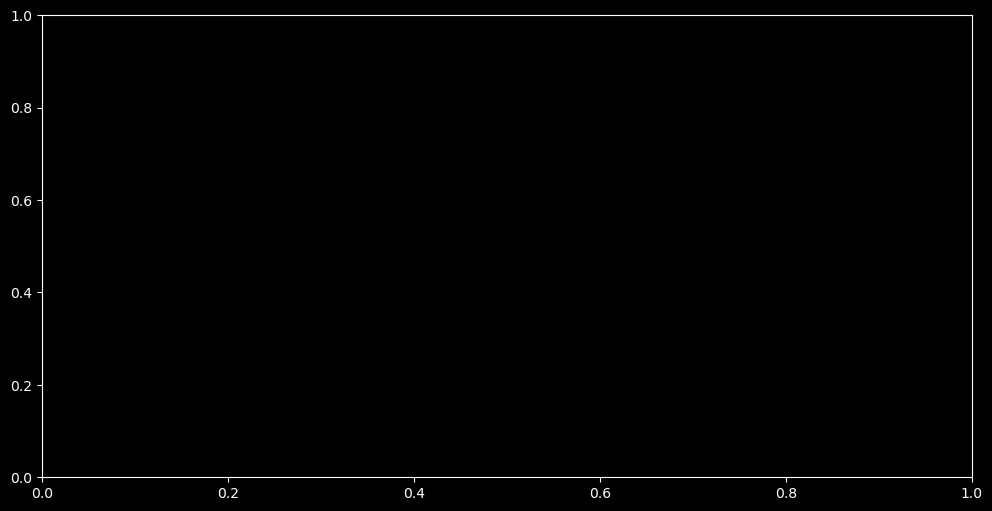

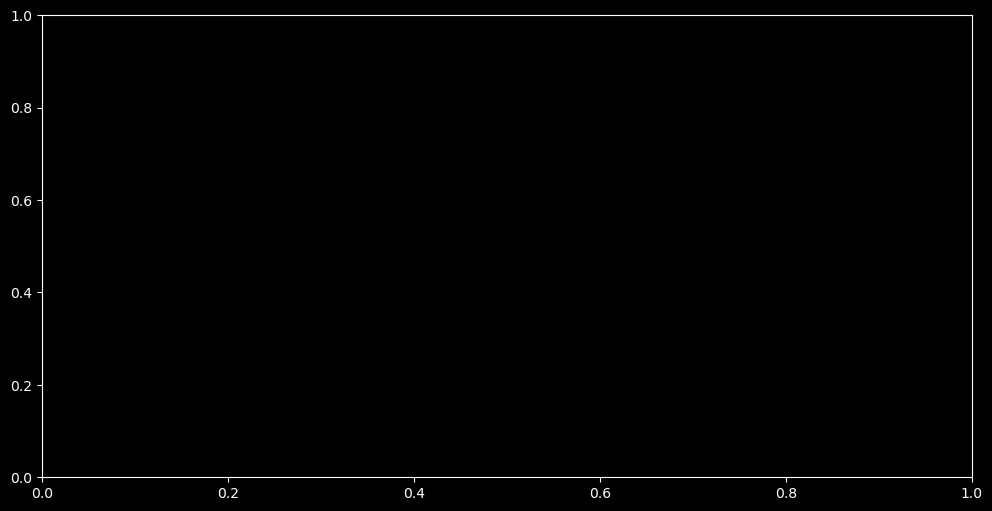

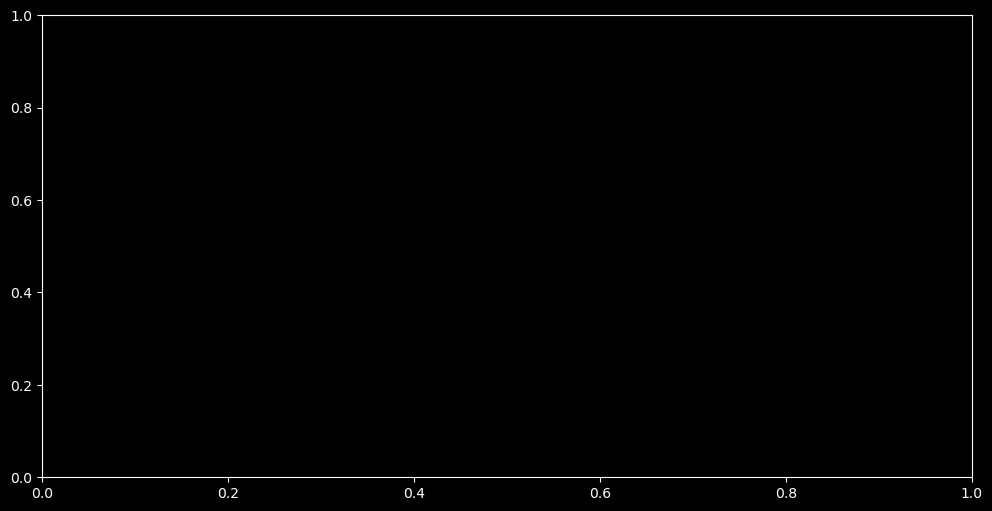

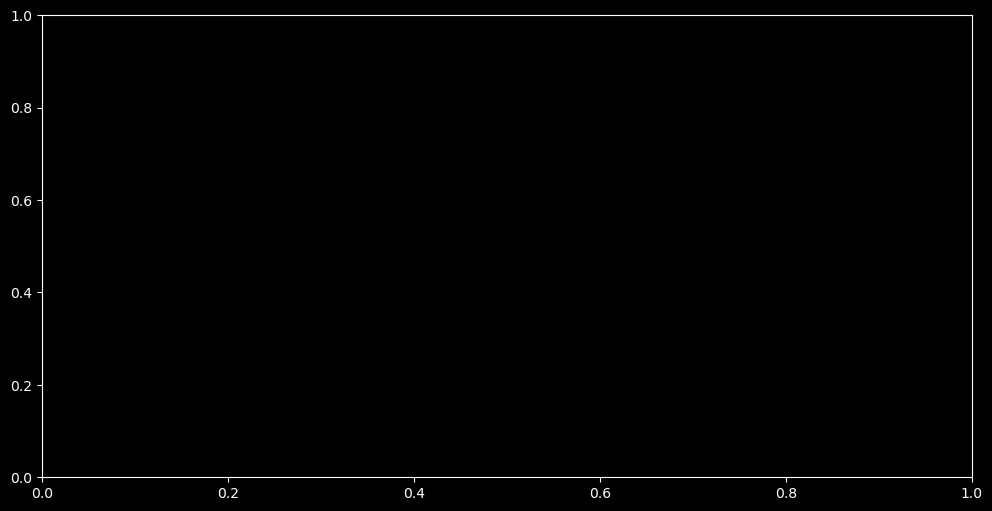

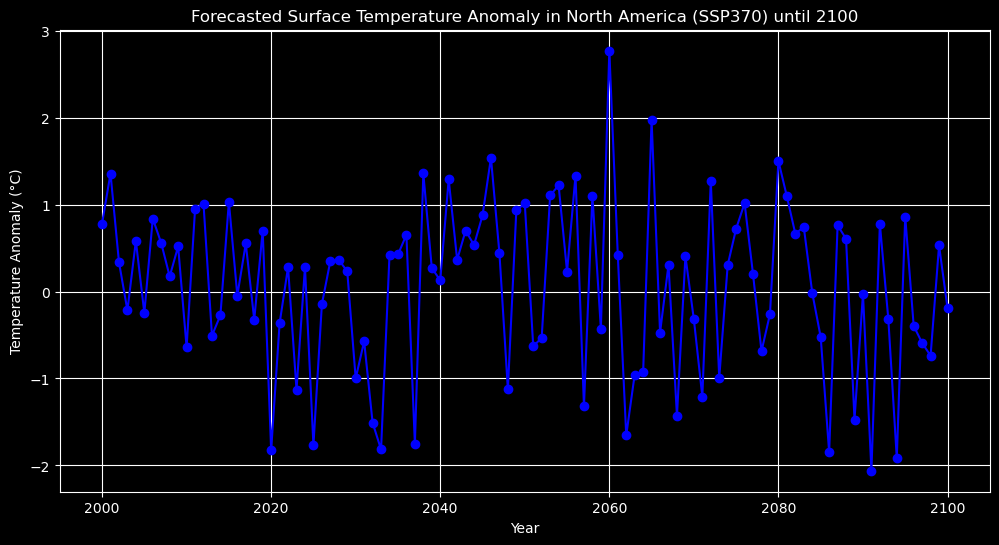

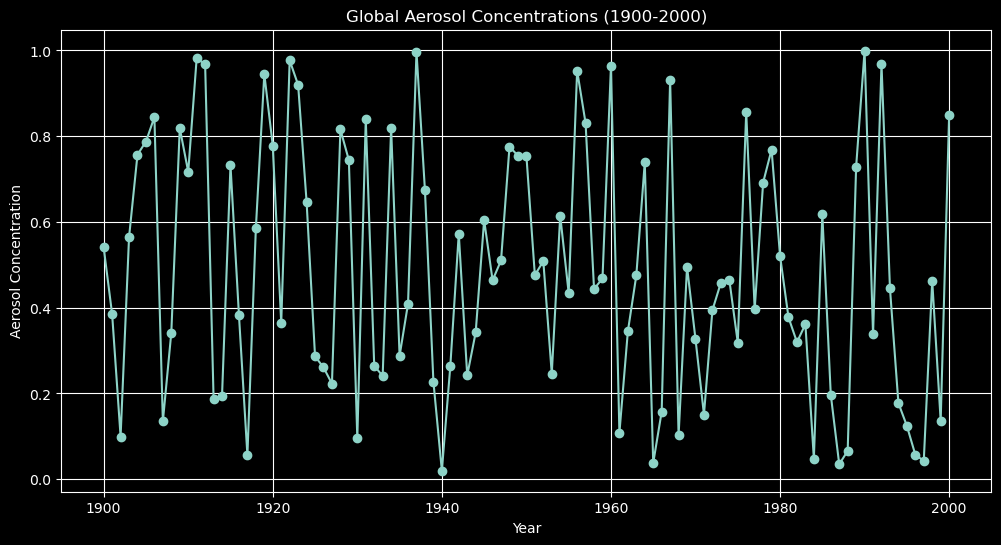

df var score 0.08571428571428569
emb var score 0.35238095238095224
year 0.6428571428571411
resolution 0.12857142857142853
mip 0.14285714285714285
experiment 0.6238095238095227
semantic to preds {'variable': 0.9999999999999976, 'start year': 0.16190476190476194, 'end year': 0.3476190476190475, 'temporal resolution': 0.9380952380952359, 'experiment': 0.9952380952380928, 'MIP': 0.9999999999999976}
semantic+varagent to preds {'variable': 0.01904761904761905, 'start year': 0.6571428571428559, 'end year': 0.3714285714285712, 'temporal resolution': 0.9142857142857121, 'experiment': 0.9714285714285691, 'MIP': 0.9999999999999976}
dfagent to gold {'variable': 0.08571428571428569, 'start year': 0, 'end year': 0.057142857142857134, 'temporal resolution': 0.7714285714285698, 'experiment': 0.3999999999999997, 'MIP': 0.42857142857142816}
semantic to gold {'variable': 0.35238095238095224, 'start year': 0.16190476190476194, 'end year': 0.3476190476190475, 'temporal resolution': 0.8142857142857125, 'exp

In [17]:
vardfscore = 0
varembscore = 0
yrscore = 0
resscore = 0
mipscore = 0
expscore = 0

predurlscore2 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics
predurlscore3 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics + varsdf agent

goldurlscore1 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #overall df pd agent
goldurlscore2 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics
goldurlscore3 = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0} #semantics + varsdf agent

for i, r in queries.iterrows():
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
    
    # VARIABLE
    try:
        var_agent = base_varpd.invoke(standalone)['output'] # pandas agent
    except:
        var_agent = None
    var_emb = find_relevant_variables(standalone).iloc[0]['variable'] # semantic/embeddings
    variablesgold = set(r['variable'].split(', ')) # true answer
    if var_agent in variablesgold or 'etc' in variablesgold:
        vardfscore += 1/len(queries)
    if var_emb in variablesgold or 'etc' in variablesgold:
        varembscore += 1/len(queries)
    
    # YEAR
    pred_startyr, pred_endyr = base_years(standalone)
    if r['start year'] <= pred_startyr:
        yrscore += 0.5/len(queries)
    if pred_endyr <= r['end year']:
        yrscore += 0.5/len(queries)
    
    # TEMPORAL RESOLUTION
    pred_reso = base_reso(standalone)
    if pred_reso == r['temporal resolution'] or (r.isna()['temporal resolution'] and pred_reso==None):
        resscore += 1/len(queries)
    
    # MIP
    pred_mip = base_mipf(standalone)
    if pred_mip == r['MIP'] or (pred_mip == None and r.isna()['MIP']):
        mipscore += 1/len(queries)
    
    # EXPERIMENT
    pred_exp = base_expf(standalone)
    if pred_exp == r['experiment'] or (pred_exp == None and r.isna()['experiment']):
        expscore += 1/len(queries)
    
    # CHOOSE DATASET
    # overall df
    chosen1 = base_datapd('plot average temperature of air')
    # grade the chosen dataset
    for descriptor_name in goldurlscore1:
        if descriptor_name == 'variable':
            if chosen1[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore1[descriptor_name] += 1/len(queries)
        else:
            if chosen1[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore1[descriptor_name] += 1/len(queries)
    
    # semantic
    preds = [('variable', var_emb), ('start year', pred_startyr), ('end year', pred_endyr),
             ('temporal resolution', pred_reso), ('experiment', pred_exp), ('MIP', pred_mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
    chosen2 = candidates.iloc[0,:]
    
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen2[descriptor_name] == descriptor_pred or descriptor_pred==None:
            predurlscore2[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen2[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore2[descriptor_name] += 1/len(queries)
        else:
            if chosen2[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore2[descriptor_name] += 1/len(queries)
    
    # semantic + varsdf agent
    preds = [('variable', var_agent), ('start year', pred_startyr), ('end year', pred_endyr),
             ('temporal resolution', pred_reso), ('experiment', pred_exp), ('MIP', pred_mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
    chosen3 = candidates.iloc[0,:]
    
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen3[descriptor_name] == descriptor_pred or descriptor_pred==None:
            predurlscore3[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen3[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore3[descriptor_name] += 1/len(queries)
        else:
            if chosen3[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore3[descriptor_name] += 1/len(queries)
                
print('df var score', vardfscore)
print('emb var score', varembscore)
print('year', yrscore)
print('resolution', resscore)
print('mip', mipscore)
print('experiment', expscore)

print("semantic to preds", predurlscore2)
print("semantic+varagent to preds", predurlscore3)

print("dfagent to gold", goldurlscore1)
print("semantic to gold", goldurlscore2)
print("semantic+varagent to gold", goldurlscore3)

# Climate PAL Results

In [21]:
len(df)

296509

In [13]:
tatk = {1:0, 3:0, 5:0, 10:0, 100:0} #top k
topscore = 0
yrscore = 0
resscore = 0
mipscore = 0
expscore = 0

predurlscore = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0}

goldurlscore = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0}

for i, r in queries.iterrows():
    # print(i, r['query'])
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
    
    # VARIABLE
    variablesdf = varagent.invoke(standalone)
    variables = variablesdf['variable'].to_list()
    variablesgold = set(r['variable'].split(', '))
    string = variablesdf.iloc[:10, :]['comment'].to_markdown()
    # print(string)
    question = f"""{r['query']}
    
    {string}"""
    # print(question)
    top = varagent2.invoke(question).content
    # print(top, variablesgold)

    for k in tatk.keys():
        tatk[k] = tatk[k] + topk(variables, variablesgold, k)/len(queries)
    if top in variablesgold or 'etc' in variablesgold:
        topscore += 1/len(queries)
    
    # YEAR
    startyr, endyr = yearagentparsed(standalone)
    # print(startyr, endyr, r['start year'], r['end year'])
    if r['start year'] <= startyr:
        yrscore += 0.5/len(queries)
    if endyr <= r['end year']:
        yrscore += 0.5/len(queries)
    
    # TEMPORAL RESOLUTION
    temporal = temporalagentparsed(standalone)
    if temporal == r['temporal resolution'] or (r.isna()['temporal resolution'] and temporal=='NA'):
        resscore += 1/len(queries)
        
    # MIP
    mip = mipagent.invoke(standalone).content
    if mip == r['MIP'] or (mip == 'None' and r.isna()['MIP']):
        mipscore += 1/len(queries)
        
    # experiment
    exp = expagent.invoke(standalone).content
    if exp == r['experiment'] or (exp == 'None' and r.isna()['experiment']):
        expscore += 1/len(queries)
        
    # choose dataset
    preds = [('variable', top), ('start year', startyr), ('end year', endyr),
             ('temporal resolution', temporal), ('experiment', exp), ('MIP', mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
            
    chosen = candidates.iloc[0,:]
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen[descriptor_name] == descriptor_pred or descriptor_pred=='None' or descriptor_pred=='NA':
            predurlscore[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore[descriptor_name] += 1/len(queries)
        else:
            if chosen[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore[descriptor_name] += 1/len(queries)
    

print('top k\t', tatk)
print('top score', topscore)
print('year', yrscore)
print('resolution', resscore)
print('mip', mipscore)
print('experiment', expscore)
print("chosen's fidelity to preds", predurlscore)
print("chosen's fidelity to gold", goldurlscore)

top k	 {1: 0.3714285714285712, 3: 0.4857142857142851, 5: 0.5190476190476183, 10: 0.6857142857142844, 100: 0.7714285714285698}
top score 0.6285714285714274
year 0.8547619047619023
resolution 0.6857142857142844
mip 0.5761904761904753
experiment 0.6238095238095227
chosen's fidelity to preds {'variable': 0.9857142857142833, 'start year': 0.26666666666666683, 'end year': 0.30000000000000004, 'temporal resolution': 0.8999999999999979, 'experiment': 0.9142857142857121, 'MIP': 0.7523809523809508}
chosen's fidelity to gold {'variable': 0.6142857142857132, 'start year': 0.3285714285714285, 'end year': 0.38571428571428545, 'temporal resolution': 0.6666666666666654, 'experiment': 0.86190476190476, 'MIP': 0.9190476190476169}


In [14]:
tatk = {1:0, 3:0, 5:0, 10:0, 100:0} #top k
topscore = 0
yrscore = 0
resscore = 0
mipscore = 0
expscore = 0

predurlscore = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0}

goldurlscore = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0}

for i, r in queries.iterrows():
    # print(i, r['query'])
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
    
    # VARIABLE
    variablesdf = varagent.invoke(standalone)
    variables = variablesdf['variable'].to_list()
    variablesgold = set(r['variable'].split(', '))
    string = variablesdf.iloc[:10, :]['comment'].to_markdown()
    # print(string)
    question = f"""{r['query']}
    
    {string}"""
    # print(question)
    top = varagent2.invoke(question).content
    # print(top, variablesgold)

    for k in tatk.keys():
        tatk[k] = tatk[k] + topk(variables, variablesgold, k)/len(queries)
    if top in variablesgold or 'etc' in variablesgold:
        topscore += 1/len(queries)
    
    # YEAR
    startyr, endyr = yearagentparsed(standalone)
    # print(startyr, endyr, r['start year'], r['end year'])
    if r['start year'] <= startyr:
        yrscore += 0.5/len(queries)
    if endyr <= r['end year']:
        yrscore += 0.5/len(queries)
    
    # TEMPORAL RESOLUTION
    temporal = temporalagentparsed(r['query'])
    if temporal == r['temporal resolution']:
        resscore += 1/len(queries)
        
    # MIP
    mip = mipagent.invoke(standalone).content
    if mip == r['MIP'] or (mip == 'None' and r.isna()['MIP']):
        mipscore += 1/len(queries)
        
    # experiment
    exp = expagent.invoke(standalone).content
    if exp == r['experiment'] or (exp == 'None' and r.isna()['experiment']):
        expscore += 1/len(queries)
        
    # choose dataset
    preds = [('variable', top), ('start year', startyr), ('end year', endyr),
             ('temporal resolution', temporal), ('experiment', exp), ('MIP', mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
            
    chosen = candidates.iloc[0,:]
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen[descriptor_name] == descriptor_pred or descriptor_pred=='None' or descriptor_pred=='NA':
            predurlscore[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore[descriptor_name] += 1/len(queries)
        else:
            if chosen[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore[descriptor_name] += 1/len(queries)
    

print('top k\t', tatk)
print('top score', topscore)
print('year', yrscore)
print('resolution', resscore)
print('mip', mipscore)
print('experiment', expscore)
print("chosen's fidelity to preds", predurlscore)
print("chosen's fidelity to gold", goldurlscore)

top k	 {1: 0.36190476190476173, 3: 0.49047619047618984, 5: 0.5190476190476183, 10: 0.6809523809523796, 100: 0.7714285714285698}
top score 0.619047619047618
year 0.8642857142857118
resolution 0.6761904761904749
mip 0.5761904761904753
experiment 0.6238095238095227
chosen's fidelity to preds {'variable': 0.9857142857142833, 'start year': 0.2619047619047621, 'end year': 0.3142857142857143, 'temporal resolution': 0.9095238095238074, 'experiment': 0.9238095238095216, 'MIP': 0.7523809523809508}
chosen's fidelity to gold {'variable': 0.6047619047619037, 'start year': 0.319047619047619, 'end year': 0.38571428571428545, 'temporal resolution': 0.6714285714285702, 'experiment': 0.8666666666666647, 'MIP': 0.9142857142857121}


In [15]:
tatk = {1:0, 3:0, 5:0, 10:0, 100:0} #top k
topscore = 0
yrscore = 0
resscore = 0
mipscore = 0
expscore = 0

predurlscore = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0}

goldurlscore = {'variable': 0, 'start year': 0, 'end year': 0,
            'temporal resolution': 0, 'experiment': 0, 'MIP': 0}

for i, r in queries.iterrows():
    # print(i, r['query'])
    conversation = {'input': r['query'], 'chat_history': []}
    standalone = chain_standalone.invoke(conversation)
    
    # VARIABLE
    variablesdf = varagent.invoke(standalone)
    variables = variablesdf['variable'].to_list()
    variablesgold = set(r['variable'].split(', '))
    string = variablesdf.iloc[:10, :]['comment'].to_markdown()
    # print(string)
    question = f"""{r['query']}
    
    {string}"""
    # print(question)
    top = varagent2.invoke(question).content
    # print(top, variablesgold)

    for k in tatk.keys():
        tatk[k] = tatk[k] + topk(variables, variablesgold, k)/len(queries)
    if top in variablesgold or 'etc' in variablesgold:
        topscore += 1/len(queries)
    
    # YEAR
    startyr, endyr = yearagentparsed(standalone)
    # print(startyr, endyr, r['start year'], r['end year'])
    if r['start year'] <= startyr:
        yrscore += 0.5/len(queries)
    if endyr <= r['end year']:
        yrscore += 0.5/len(queries)
    
    # TEMPORAL RESOLUTION
    temporal = temporalagentparsed(r['query'])
    if temporal == r['temporal resolution']:
        resscore += 1/len(queries)
        
    # MIP
    mip = mipagent.invoke(standalone).content
    if mip == r['MIP'] or (mip == 'None' and r.isna()['MIP']):
        mipscore += 1/len(queries)
        
    # experiment
    exp = expagent.invoke(standalone).content
    if exp == r['experiment'] or (exp == 'None' and r.isna()['experiment']):
        expscore += 1/len(queries)
        
    # choose dataset
    preds = [('variable', top), ('start year', startyr), ('end year', endyr),
             ('temporal resolution', temporal), ('experiment', exp), ('MIP', mip)]
    filters = [] # for debug
    candidates = df # any is candidate to start
    for descriptor_name, descriptor_value in preds:
        candidatesp = candidates[candidates[descriptor_name]==descriptor_value]
        if len(candidatesp)>0: # filter through to satisfy this descriptor
            candidates = candidatesp
            filters.append(descriptor_name)
            
    chosen = candidates.iloc[0,:]
    # grade the chosen dataset
    for descriptor_name, descriptor_pred in preds:
        if chosen[descriptor_name] == descriptor_pred or descriptor_pred=='None' or descriptor_pred=='NA':
            predurlscore[descriptor_name] += 1/len(queries)
        if descriptor_name == 'variable':
            if chosen[descriptor_name] in variablesgold or 'etc' in variablesgold:
                goldurlscore[descriptor_name] += 1/len(queries)
        else:
            if chosen[descriptor_name] == r[descriptor_name] or r.isna()[descriptor_name] or r[descriptor_name]=='NA':
                goldurlscore[descriptor_name] += 1/len(queries)
    

print('top k\t', tatk)
print('top score', topscore)
print('year', yrscore)
print('resolution', resscore)
print('mip', mipscore)
print('experiment', expscore)
print("chosen's fidelity to preds", predurlscore)
print("chosen's fidelity to gold", goldurlscore)

top k	 {1: 0.3714285714285712, 3: 0.49047619047618984, 5: 0.5190476190476183, 10: 0.6666666666666654, 100: 0.7714285714285698}
top score 0.6285714285714274
year 0.859523809523807
resolution 0.6857142857142844
mip 0.58095238095238
experiment 0.6142857142857132
chosen's fidelity to preds {'variable': 0.9809523809523786, 'start year': 0.2619047619047621, 'end year': 0.3047619047619048, 'temporal resolution': 0.9142857142857121, 'experiment': 0.9095238095238074, 'MIP': 0.7428571428571413}
chosen's fidelity to gold {'variable': 0.6095238095238085, 'start year': 0.30952380952380953, 'end year': 0.38571428571428545, 'temporal resolution': 0.6714285714285702, 'experiment': 0.8523809523809505, 'MIP': 0.9190476190476169}
